In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import BCI_analysis
import os
import numpy as np
import matplotlib.pyplot as plt
import oasis
#mpld3.enable_notebook()

# - hard-coded variables - should go to a json file
local_temp_dir = '/home/jupyter/temp/' 
metadata_dir = '/home/jupyter/bucket/Metadata/' 
raw_scanimage_dir_base ='/home/jupyter/bucket/Data/Calcium_imaging/raw/' 
suite2p_dir_base = '/home/jupyter/bucket/Data/Calcium_imaging/suite2p/'
bpod_path = '/home/jupyter/bucket/Data/Behavior/BCI_exported/'
from oasis.functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters

setup = 'Bergamo-2P-Photostim'
sessionwise_path_base = "/home/jupyter/bucket/Data/Calcium_imaging/sessionwise_tba"

# - convenience functions
def load_and_calculate_dff(directory,scalar_f0 = False,photostim = False,correct_offset = False,moving_average_window = np.nan):
    """
    """
    
    F = np.load(os.path.join(directory,'F.npy'))
    Fneu = np.load(os.path.join(directory,'Fneu.npy'))
    F0 = np.load(os.path.join(directory,'F0.npy'))
    
    if correct_offset:
        f0_correction_dict = np.load(os.path.join(directory,'channel_offset.npy'),allow_pickle=True).tolist()
        
        F+=f0_correction_dict['channel_offset']
        F0+=f0_correction_dict['channel_offset']
        Fneu+=f0_correction_dict['channel_offset']
        print('corrected offset: {}'.format(f0_correction_dict['channel_offset']))
    F0_scalar = np.nanmedian(F0,1)[:,np.newaxis]
    
    if photostim:
        ops =  np.load(os.path.join(directory,'ops.npy'),allow_pickle = True).tolist()
        F,Fneu = BCI_analysis.io_suite2p.remove_stim_artefacts(F,Fneu,ops['frames_per_file'])
    if scalar_f0:
        dFF = (F-F0_scalar)/F0_scalar
    else:
        dFF = (F-F0)/F0
    
    
    if np.isnan(moving_average_window):
        return dFF,F,F0,F0_scalar,Fneu
    else:
        try:
            photon_counts = np.load(os.path.join(directory,'photon_counts.npy'),allow_pickle= True).tolist()
        except:
            print('no photon counts file found, going a directory above')
            dir_now,_ = os.path.split(directory)
            photon_counts = np.load(os.path.join(dir_now,'photon_counts.npy'),allow_pickle= True).tolist()
        f0_photon_counts_per_roi = photon_counts['F0_photon_counts']*moving_average_window
        dFF_filt = []
        for f in dFF:
            dFF_filt.append(BCI_analysis.pipeline_utils.rollingfun(f,moving_average_window))
        dFF_filt = np.asarray(dFF_filt)
        signal_photon_count =(dFF_filt)*f0_photon_counts_per_roi[:,np.newaxis] 
        noise_photon_count = (dFF_filt+1)*f0_photon_counts_per_roi[:,np.newaxis]
        snr_trace = signal_photon_count/np.sqrt(noise_photon_count)
        return dFF,F,F0,F0_scalar,Fneu,snr_trace


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/jupyter/Scripts/OASIS/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


/home/jupyter/Scripts/OASIS/oasis/functions.py:15: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


cell started
tau corrected in 10 steps, from 2.439 s to 4.706 s


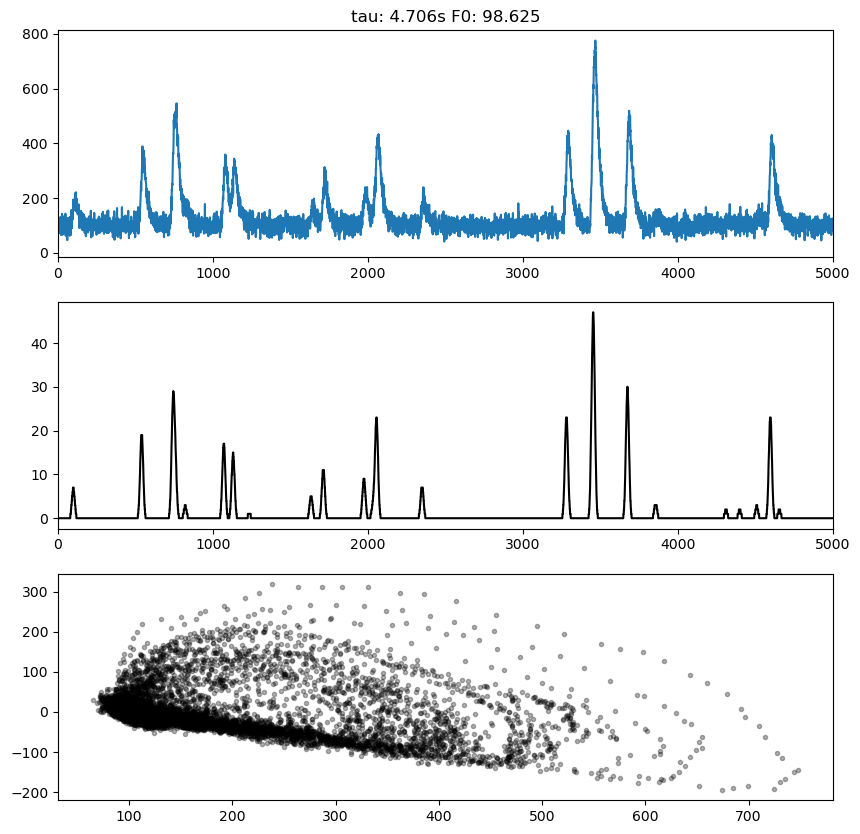

In [364]:
# play with modeled data - non-Poisson spiking is needed for slow decay times # load the functions first in below cells
from oasis.functions import gen_data

tau = 1.2 #s
g = [np.exp((-1*0.05)/tau)]
F0 = 100
F_trace, true_c, true_s = map(np.squeeze, gen_data(N=1, 
                                             b=F0, 
                                             seed=0,
                                            g = g,
                                            T = 15000,
                                            framerate = 20,
                                            firerate = .1,
                                                  sn = 20))


tau_calc,b_calc = calculate_f0_tau(F_trace,F0)
fig = plt.figure(figsize = [10,10])
ax_f = fig.add_subplot(3,1,1)
ax_f.plot(F_trace)
ax_f.set_title('tau: {:.3f}s F0: {}'.format(tau_calc,round(b_calc,3)))
ax_s = fig.add_subplot(3,1,2,sharex = ax_f)
ax_s.plot(true_s,'k-')
ax_s.set_xlim([0,5000])
f0 = BCI_analysis.pipeline_utils.rollingfun(F_trace,baseline_length)
fpeak = BCI_analysis.pipeline_utils.rollingfun(F_trace,peak_length)
amplitudes = fpeak[offset:]-f0[:-offset]
f0s = f0[:-offset]
correction = f0s - (f0s-b)*(g[0]**offset) - b
amplitudes_corrected = amplitudes+correction

ax_ampl = fig.add_subplot(3,1,3)
ax_ampl.plot(f0s, amplitudes,'k.',alpha = .3)

In [6]:
#### select sessions
subject = 'BCI_34'
fov = 'FOV_03'#'FOV_01'
sessions = ['071322','071422']

In [7]:
#### select cells that show any activity in BOTH sessions
snr_cutoff = 5
activity_ratio_cutoff = .01
stat = np.load(os.path.join(suite2p_dir_base,setup,subject,fov,'stat.npy'), allow_pickle = True).tolist()
snr_list = []
for session in sessions:
    scalar_f0 = False
    correct_offset = False
    session_dir = os.path.join(suite2p_dir_base,setup,subject,fov,session)
    photostim_dir = os.path.join(session_dir,'photostim')
    photostim_groups = np.load(os.path.join(photostim_dir,'photostim_groups.npy'),allow_pickle=True).tolist()
    dFF_photostim,F_photostim,F0_photostim,F0_scalar_photostim,Fneu_photostim,snr_trace = load_and_calculate_dff(photostim_dir,
                                                                                                                scalar_f0 = scalar_f0,
                                                                                                                photostim = True,
                                                                                                                correct_offset = correct_offset,
                                                                                                                moving_average_window = 4)
    snr_list.append(np.sum(snr_trace>10,1)/snr_trace.shape[1])
needed_cells_with_activity = np.where(np.min(snr_list,0)>activity_ratio_cutoff)[0]



#needed_cells_with_activity = np.arange(20)



print('{} cells selected'.format(len(needed_cells_with_activity)))

stat = np.asarray(np.load(os.path.join(suite2p_dir_base,setup,subject,fov,'stat.npy'), allow_pickle = True).tolist())[needed_cells_with_activity]

photostim offset from trial start is 0 frames
no photon counts file found, going a directory above


/tmp/ipykernel_27304/1902131839.py:65: RuntimeWarning: invalid value encountered in sqrt
  snr_trace = signal_photon_count/np.sqrt(noise_photon_count)


photostim offset from trial start is 0 frames
no photon counts file found, going a directory above
263 cells selected


/tmp/ipykernel_27304/1902131839.py:65: RuntimeWarning: invalid value encountered in sqrt
  snr_trace = signal_photon_count/np.sqrt(noise_photon_count)


In [10]:
# linear regression on the F0 of all cells to predict df of a selected cell
from sklearn.linear_model import LassoCV,RidgeCV
cell_to_predict = 26
F_matrix = F_photostim[needed_cells_with_activity,:]
F0s = np.asarray(photostim_data_dict[session]['fitted_f0'])
F_start_matrix = []
F_peak_matrix = []
for f in F_matrix:
    F_start_matrix.append(np.convolve(f,np.ones([baseline_length])/baseline_length,mode = 'same'))
    F_peak_matrix.append(np.convolve(f,np.ones([baseline_length])/peak_length,mode = 'same'))
F_start_matrix = np.asarray(F_start_matrix)
F_peak_matrix = np.asarray(F_peak_matrix)
                          
                      
f0_matrix = F_start_matrix[:,:-offset]
f1_matrix = F_start_matrix[:,offset:]
amplitudes_matrix = f1_matrix-f0_matrix
amplitudes = amplitudes_matrix[cell_to_predict,]
f0_matrix =  f0_matrix -F0s[:,np.newaxis]

# clf = Ridge(alpha=1.0)
# clf.fit(f0_matrix.T, amplitudes)
# reg = LassoCV(cv=5, random_state=0).fit(f0_matrix.T, amplitudes)
# reg.score(f0_matrix.T,amplitudes)


clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(f0_matrix.T, amplitudes)
clf.score(f0_matrix.T, amplitudes)

NameError: name 'photostim_data_dict' is not defined

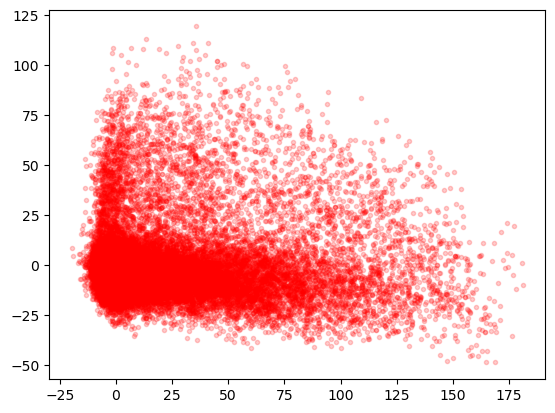

In [119]:
#reg.score(f0_matrix.T,amplitudes)
#plt.plot(reg.coef_)
#plt.plot(clf.coef_)
amplitudes_pred = clf.predict(f0_matrix.T)
#plt.plot(amplitudes,amplitudes_pred,'k.',alpha = .2)
#plt.plot(f0_matrix[cell_to_predict,:],amplitudes,'k.',alpha = .2)
plt.plot(f0_matrix[cell_to_predict,:],amplitudes-amplitudes_pred,'r.',alpha = .2)

In [8]:
#### estimate time constants based on measured amplitudes
import random
import warnings
import multiprocessing as mp

correct_slow_drift = False # estimates slow linear drift over the whole session based on changes in F0
correct_tau = False # changes tau until the expeced amplitudes don't depend linearly on f0 anymore
tau_corr_cutoff = .01 # this is the maximum |correlation| that is accepted when correcting the tau
warnings.filterwarnings(action='ignore', message='Mean of empty slice')

# parameters = {'bootstrap_n' : 50.
#               'bootstrap_r' : 1.0,
#               'dff_range' : [0,4],
#               'minimum_dff_max' : 2,
#               'bin_num' : 5,
#               'deconvolution_type' : 'oasis',
#               'correct_tau' : False,
#               'baseline_length' : 5,
#               'peak_length' : 5,
#               'offset' : 11, # frame offset where the amplitude will be measured
#               'tau_corr_cutoff' : .01}

def calculate_f0_tau(F_trace,F0):
    #print('cell started')
    
    # marton decay and F0 parameters
    bootstrap_n = 50 # 
    bootstrap_r = 1.0
    dff_range = [0,4]
    minimum_dff_max = 2
    bin_num = 5
    # marton decay and F0 parameters
    
    deconvolution_type = 'oasis'
    correct_tau = False
    baseline_length = 5
    peak_length = 5
    offset = 11 # frame offset where the amplitude will be measured
    tau_corr_cutoff = .01
    
    n_random_groups_per_stimgroup_per_cell = 20
    
    
    
    f0 = BCI_analysis.pipeline_utils.rollingfun(F_trace,baseline_length)
    fpeak = BCI_analysis.pipeline_utils.rollingfun(F_trace,peak_length)
    amplitudes_ = fpeak[offset:]-f0[:-offset]
    f0s_ = f0[:-offset]
    taus_bootstrap = []
    f0_bootstrap = []
    for bootstrap_i in range(bootstrap_n):
        indices = np.random.choice(np.arange(len(amplitudes_)),int(len(amplitudes_)*bootstrap_r))
        amplitudes = amplitudes_[indices]
        f0s = f0s_[indices]

        corrcoeff = 0
        diff_max_offset =0
        if minimum_dff_max<dff_range[1]+diff_max_offset:
            while corrcoeff <.975 and minimum_dff_max<dff_range[1]+diff_max_offset:
                x_range = np.percentile(f0s,[1,99])
                x_range[0] = np.max([F0*(dff_range[0]+1),x_range[0]])
                x_range[1] = np.min([F0*(dff_range[1]+diff_max_offset+1),x_range[1]])
                f0s_used = f0s[(f0s>x_range[0])&(f0s<x_range[1])]
                


                bin_mean = []
                bin_center = []
                bin_std = []
                bin_n = []
                if x_range[0]>x_range[1] or len(f0s_used)<100:
                    break # we break out of this loop if there are no values in the range..
                for bin_i in np.arange(bin_num):
                    min_x_val = x_range[0]+bin_i*np.diff(x_range)/bin_num
                    max_x_val = x_range[0]+(bin_i+1)*np.diff(x_range)/bin_num
                    # min_x_val = np.percentile(f0s_used,lower_percentiles[bin_i])
                    # max_x_val = np.percentile(f0s_used,upper_percentiles[bin_i])


                    needed_idx = (f0s>min_x_val) & (f0s<max_x_val)
                    f0_now = f0s[needed_idx]
                    amplitudes_now = amplitudes[needed_idx]
                    amplitudes_now = amplitudes_now[np.isnan(amplitudes_now)==False]
                    while len(amplitudes_now)>10:
                        y,x = np.histogram(amplitudes_now,10)
                        x = np.nanmean([x[:-1],x[1:]],0)
                        range_now = (np.nanmax(amplitudes_now) - np.nanmin(amplitudes_now))/5
                        center_val = x[np.argmax(y)]
                        needed = (amplitudes_now>center_val-range_now) & (amplitudes_now<center_val+range_now)
                        amplitudes_now = amplitudes_now[needed]
                    n = len(needed_idx)
                    bin_center.append(np.nanmean(f0_now))
                    bin_mean.append(np.nanmean(amplitudes_now))
                    bin_std.append(0)
                    bin_n.append(n)
                    # if np.isnan(np.nanmean(f0_now)) or np.isnan(np.nanmean(amplitudes_now)):
                    #     adasd
                try:
                    p = np.polyfit(bin_mean,bin_center,1)
                except:
                    p = [0,0]
                    #print('could not fit')
                corrcoeff = -1*np.corrcoef(bin_mean,bin_center)[0,1]
                if corrcoeff<.975:
                    diff_max_offset-=.5
            needed_bin = (np.isnan(bin_center) == False) & (np.isnan(bin_mean) == False)
        if corrcoeff>.9:
            f0_calc = p[1]
            f0_bootstrap.append(f0_calc)
    if len(f0_bootstrap)>bootstrap_n/2:
        b = np.nanmedian(f0_bootstrap)
    else:
        print('could not estimate F0 presumably due to low activity, falling back to previous estimate')
        b = F0


    g = oasis.functions.estimate_time_constant(F_trace,p=1,lags = 40) # estimate tau with oasis
    tau_real = (-.05)/np.log(g)[0]

    if correct_tau: # this one fine-tunes tau for each cell based on the distribution of expected amplitudes
        
        r_df_corr_vs_f0 = np.inf
        tau_candidates_ = []
        corrcoeffs_corrected_ = []
        corrcoeffs_ = []
        while np.abs(r_df_corr_vs_f0)>tau_corr_cutoff:
            g = np.exp((-1*0.05)/tau_real)

            amplitudes = fpeak[offset:]-f0[:-offset]
            f0s = f0[:-offset]
            
            # #### use only values where the starting dF/F is bigger than some arbitrary value
            # needed = (f0s-b)/b >min_dff_to_use
            # amplitudes = amplitudes[needed]
            # f0s = f0s[needed]
            # #### use only values where the starting dF/F is bigger than some arbitrary value
            
            correction = f0s - (f0s-b)*(g**offset) - b
            amplitudes_corrected = amplitudes+correction
            
            
            

            group_mean_amplitudes_random = []
            group_mean_amplitudes_random_corrected = []
            group_mean_f0s_random = []
            group_percentiles = []
            for group_idx in range(len(photostim_groups['groups'])):
                repeats = sum(np.asarray(photostim_groups['group_order'])==group_idx)

                mean_amplitudes_corrected = []
                mean_amplitudes = []
                mean_f0s = []
                for i in range(n_random_groups_per_stimgroup_per_cell):
                    random_indices = random.sample(range(len(amplitudes_corrected)),repeats)
                    mean_amplitudes_corrected.append(np.nanmean(amplitudes_corrected[random_indices]))
                    mean_amplitudes.append(np.nanmean(amplitudes[random_indices]))
                    mean_f0s.append(np.nanmean(f0s[random_indices]))

                group_mean_amplitudes_random_corrected.append(mean_amplitudes_corrected)
                group_mean_amplitudes_random.append(mean_amplitudes)
                group_mean_f0s_random.append(mean_f0s)
            r_df_vs_f0 = np.corrcoef( np.concatenate(group_mean_f0s_random),np.concatenate(group_mean_amplitudes_random))[0][1]
            r_df_corr_vs_f0  = np.corrcoef( np.concatenate(group_mean_f0s_random),np.concatenate(group_mean_amplitudes_random_corrected))[0][1]
            tau_candidates_.append(tau_real)
            corrcoeffs_corrected_.append(r_df_corr_vs_f0)
            corrcoeffs_.append(r_df_vs_f0)
            if r_df_corr_vs_f0 > tau_corr_cutoff:
                tau_real = tau_real*1.1
            elif r_df_corr_vs_f0 < -1*tau_corr_cutoff:
                tau_real = tau_real*.9

        #print('tau corrected in {} steps, from {:.3f} s to {:.3f} s'.format(len(tau_candidates_),tau_candidates_[0],tau_candidates_[-1]))
    return tau_real,b

photostim_data_dict = {}


pool = mp.Pool(mp.cpu_count())


spikes_matrix = []

if __name__ == "__main__":

    for session in sessions:
        scalar_f0 = False
        correct_offset = False
        session_dir = os.path.join(suite2p_dir_base,setup,subject,fov,session)
        photostim_dir = os.path.join(session_dir,'photostim')
        dFF_photostim,F_photostim,F0_photostim,F0_scalar_photostim,Fneu_photostim = load_and_calculate_dff(photostim_dir,
                                                                                scalar_f0 = scalar_f0,
                                                                                photostim = True,
                                                                                correct_offset = correct_offset)


        if correct_slow_drift:
            x = np.arange(len(np.mean(F0_photostim,0)))
            y_nonnorm = np.mean(F0_photostim,0)
            y = y_nonnorm/np.mean(y_nonnorm[0:1000])
            p_slow_drif = np.polyfit(x,y,1)
            print('slow decay is {:.3f}% per minute'.format(p_slow_drif[0]*20*60*100))


        calculated_f0s = []
        calculated_taus = []
        cell_results = []
        for cell_idx in needed_cells_with_activity:#range(len(F0_scalar_photostim)):
            F0 = F0_scalar_photostim[cell_idx][0]
            F_trace = F_photostim[cell_idx,:]
            if correct_slow_drift:
                x = np.arange(len(np.mean(F0_photostim,0)))
                correction = x*(p_slow_drif[0])*F_trace
                F_trace -= correction
                F0 = F0_photostim[cell_idx,:]
                correction = x*(p_slow_drif[0])*F0
                F0 -= correction
                F0 = np.nanmedian(F0)

            ##F_trace = F_session[cell_idx,:]

            #tau_real,b = calculate_f0_tau(F_trace,F0)
            cell_results.append(pool.apply_async(calculate_f0_tau, (F_trace, F0)))
            # calculated_f0s.append(b)
            # calculated_taus.append(tau_real)#p[0]*-1)
        print('calculating taus for {}'.format(session))            
        ready_cell = []
        prev_percentage = 0
        percentage = 0
        while sum(ready_cell) < len(cell_results):
            ready_cell = []
            for result in cell_results:
                ready_cell.append(result.ready())
            percentage = np.round(100*sum(ready_cell)/len(cell_results))
            if percentage>prev_percentage+4:
                print('{}%'.format(percentage))
                prev_percentage = percentage



        #[result.wait() for result in cell_results]
        for result in cell_results:
            calculated_taus.append(result.get()[0])
            calculated_f0s.append(result.get()[1])
        #asd


               # sdas

        photostim_data_dict[session] = {}
        photostim_data_dict[session]['F0'] = F0_scalar_photostim
        photostim_data_dict[session]['fitted_f0'] = calculated_f0s  
        photostim_data_dict[session]['fitted_tau'] = calculated_taus  
        photostim_data_dict[session]['cell_indices'] = needed_cells_with_activity

pool.close()  

photostim offset from trial start is 0 frames
calculating taus for 071322
could not estimate F0 presumably due to low activity, falling back to previous estimate
could not estimate F0 presumably due to low activity, falling back to previous estimate
could not estimate F0 presumably due to low activity, falling back to previous estimate
5.0%
could not estimate F0 presumably due to low activity, falling back to previous estimate
could not estimate F0 presumably due to low activity, falling back to previous estimate
10.0%
15.0%
20.0%
25.0%
could not estimate F0 presumably due to low activity, falling back to previous estimate
30.0%
could not estimate F0 presumably due to low activity, falling back to previous estimate
35.0%
could not estimate F0 presumably due to low activity, falling back to previous estimate
40.0%
45.0%
could not estimate F0 presumably due to low activity, falling back to previous estimate
50.0%
could not estimate F0 presumably due to low activity, falling back to previ

In [5]:
pool.close()  

In [ ]:
# ezt beleztem ki az alabbi scriptbol

amplitudes_ = fpeak[offset:]-f0[:-offset]
        f0s_ = f0[:-offset]
        taus_bootstrap = []
        f0_bootstrap = []
        for bootstrap_i in range(bootstrap_n):
            indices = random.sample(list(np.arange(len(amplitudes_))),int(len(amplitudes_)*bootstrap_r))
            amplitudes = amplitudes_[indices]
            f0s = f0s_[indices]

            corrcoeff = 0
            diff_max_offset =0
            while corrcoeff <.975 and minimum_dff_max<dff_range[1]+diff_max_offset:
                x_range = np.percentile(f0s,[1,99])
                x_range[0] = np.max([F0*(dff_range[0]+1),x_range[0]])
                x_range[1] = np.min([F0*(dff_range[1]+diff_max_offset+1),x_range[1]])
                f0s_used = f0s[(f0s>x_range[0])&(f0s<x_range[1])]
                if x_range[0]>x_range[1] or len(f0s_used)<100:
                    break # we break out of this loop if there are no values in the range..


                bin_mean = []
                bin_center = []
                bin_std = []
                bin_n = []


                # lower_percentiles = 100*np.arange(bin_num)/bin_num
                # upper_percentiles = 100*np.arange(bin_num)/bin_num+1/bin_num

                for bin_i in np.arange(bin_num):
                    min_x_val = x_range[0]+bin_i*np.diff(x_range)/bin_num
                    max_x_val = x_range[0]+(bin_i+1)*np.diff(x_range)/bin_num
                    # min_x_val = np.percentile(f0s_used,lower_percentiles[bin_i])
                    # max_x_val = np.percentile(f0s_used,upper_percentiles[bin_i])


                    needed_idx = (f0s>min_x_val) & (f0s<max_x_val)
                    f0_now = f0s[needed_idx]
                    amplitudes_now = amplitudes[needed_idx]
                    amplitudes_now = amplitudes_now[np.isnan(amplitudes_now)==False]
                    while len(amplitudes_now)>10:
                        y,x = np.histogram(amplitudes_now,10)
                        x = np.nanmean([x[:-1],x[1:]],0)
                        range_now = (np.nanmax(amplitudes_now) - np.nanmin(amplitudes_now))/5
                        center_val = x[np.argmax(y)]
                        needed = (amplitudes_now>center_val-range_now) & (amplitudes_now<center_val+range_now)
                        amplitudes_now = amplitudes_now[needed]
                    n = len(needed_idx)
                    bin_center.append(np.nanmean(f0_now))
                    bin_mean.append(np.nanmean(amplitudes_now))
                    bin_std.append(0)
                    bin_n.append(n)
                    # if np.isnan(np.nanmean(f0_now)) or np.isnan(np.nanmean(amplitudes_now)):
                    #     adasd
                try:
                    p = np.polyfit(bin_mean,bin_center,1)
                except:
                    p = [0,0]
                    #print('could not fit')
                corrcoeff = -1*np.corrcoef(bin_mean,bin_center)[0,1]
                if corrcoeff<.975:
                    diff_max_offset-=.5
            needed_bin = (np.isnan(bin_center) == False) & (np.isnan(bin_mean) == False)

            pp =  np.polyfit(np.asarray(bin_center)[needed_bin],np.asarray(bin_mean)[needed_bin],1)
            m = pp[0]
            if (1+m)/1<0:
                tau_real = np.nan
            else:
                tau_real = (- 1*offset*.05)/(np.log((1+m)/1))
            f0_calc = p[1]
            taus_bootstrap.append(tau_real)
            f0_bootstrap.append(f0_calc)
        tau_real = np.nanmedian(taus_bootstrap)
        b = np.nanmedian(f0_bootstrap)
        g = np.exp((-1*0.05)/tau_real)
        

        if deconvolution_type == 'oasis':
                        
            g = oasis.functions.estimate_time_constant(F_trace,p=1,lags = 40)
            # c, s, b_, g_, lam = deconvolve(F_trace, penalty=1,g = g, b = b) # use the background estimate from Marton's way, and use the time constant from oasis
            # spikes_matrix.append(s)
            
            tau_real = (-.05)/np.log(g)[0]
         
        if correct_tau: # this one fine-tunes tau for each cell based on the distribution of expected amplitudes
            r_df_corr_vs_f0 = np.inf
            tau_candidates_ = []
            corrcoeffs_corrected_ = []
            corrcoeffs_ = []
            while np.abs(r_df_corr_vs_f0)>tau_corr_cutoff:
                g = np.exp((-1*0.05)/tau_real)

                amplitudes = fpeak[offset_tau:]-f0[:-offset_tau]
                f0s = f0[:-offset_tau]
                
                # needed_f0s = f0s>F0*1.5
                # amplitudes = amplitudes[needed_f0s]
                # f0s = f0s[needed_f0s]
                
                
                correction = f0s - (f0s-b)*(g**offset_tau) - b
                amplitudes_corrected = amplitudes+correction

                group_mean_amplitudes_random = []
                group_mean_amplitudes_random_corrected = []
                group_mean_f0s_random = []
                group_percentiles = []
                for group_idx in range(len(photostim_groups['groups'])):
                    repeats = sum(np.asarray(photostim_groups['group_order'])==group_idx)
                    mean_amplitudes_corrected = []
                    mean_amplitudes = []
                    mean_f0s = []
                    for i in range(n_random_groups_per_stimgroup_per_cell):
                        random_indices = random.sample(range(len(amplitudes_corrected)),repeats)
                        mean_amplitudes_corrected.append(np.nanmean(amplitudes_corrected[random_indices]))
                        mean_amplitudes.append(np.nanmean(amplitudes[random_indices]))
                        mean_f0s.append(np.nanmean(f0s[random_indices]))

                    group_mean_amplitudes_random_corrected.append(mean_amplitudes_corrected)
                    group_mean_amplitudes_random.append(mean_amplitudes)
                    group_mean_f0s_random.append(mean_f0s)
                r_df_vs_f0 = np.corrcoef( np.concatenate(group_mean_f0s_random),np.concatenate(group_mean_amplitudes_random))[0][1]
                r_df_corr_vs_f0  = np.corrcoef( np.concatenate(group_mean_f0s_random),np.concatenate(group_mean_amplitudes_random_corrected))[0][1]
                tau_candidates_.append(tau_real)
                corrcoeffs_corrected_.append(r_df_corr_vs_f0)
                corrcoeffs_.append(r_df_vs_f0)
                if r_df_corr_vs_f0 > tau_corr_cutoff:
                    tau_real = tau_real*1.1
                elif r_df_corr_vs_f0 < -1*tau_corr_cutoff:
                    tau_real = tau_real*.9
            
            print('tau corrected in {} steps, from {:.3f} s to {:.3f} s'.format(len(tau_candidates_),tau_candidates_[0],tau_candidates_[-1]))
            # if tau_real<1:
            #     tau_real = 1
            g = np.exp((-1*0.05)/tau_real)

In [13]:
a = F_photostim_aligned[:,cell_idx,:]
a.shape

(60, 2029)

In [123]:
F_photostim_aligned[:,:,photostim_group_order==group_idx].shape
F0s_matrix = np.nanmean(F_photostim_aligned[baseline_offset:baseline_offset+baseline_length,:,:],0)
F0s_all.shape

(1078, 2029)

In [11]:
# correcting photostim amplitudes with the tau and F0 values calculated above


# TODO: try sampling only from the photostim timepoints - to get rid of the messed up inhibition
import random
import warnings
import tqdm
from sklearn.linear_model import LassoCV,RidgeCV

step_back = 20
step_forward = 40
baseline_offset = 12 #from step_back
baseline_length = 5# from -baseline_offset
peak_length = 5 #from peak_offset
peak_offset = 3##from trial start - gap

offset_photostim = int(step_back-baseline_offset-baseline_length/2 + peak_length/2 + peak_offset) # for correcting amplitudes
offset =  offset_photostim#20# # for measuring decay time, in frames
n_random_groups_per_stimgroup_per_cell = 100
sample_only_at_photostim = False
do_regression = True

def correct_amplitudes_generate_distribution(F_matrix,
                                             F0s,
                                             F_trace,
                                             cell_idx,
                                             F_photostim_aligned,
                                             photostim_group_order,
                                             cell_percentile_values,
                                             b,
                                             g):
    #print('starting cell {}'.format(cell_idx))
    step_back = 20
    step_forward = 40
    baseline_offset = 12 #from step_back
    baseline_length = 5# from -baseline_offset
    peak_length = 5 #from peak_offset
    peak_offset = 3##from trial start - gap
    
    offset_photostim = int(step_back-baseline_offset-baseline_length/2 + peak_length/2 + peak_offset) # for correcting amplitudes
    offset =  offset_photostim#20# # for measuring decay time, in frames
    n_random_groups_per_stimgroup_per_cell = 20
    sample_only_at_photostim = False 
    do_regression = True
    
    corrected_group_amplitudes_all = []
    group_amplitudes_all = []
    group_f0s_all = []
    group_mean_amplitudes_random = []
    group_mean_amplitudes_random_corrected = []
    group_mean_f0s_random = []
    group_percentiles = []

    f0 = BCI_analysis.pipeline_utils.rollingfun(F_trace,baseline_length)
    fpeak = BCI_analysis.pipeline_utils.rollingfun(F_trace,peak_length)
    amplitudes = fpeak[offset:]-f0[:-offset]
    f0s = f0[:-offset]
    if do_regression:
        F_start_matrix = []
        F_peak_matrix = []
        for f in F_matrix:
            F_start_matrix.append(np.convolve(f,np.ones([baseline_length])/baseline_length,mode = 'same'))
            F_peak_matrix.append(np.convolve(f,np.ones([baseline_length])/peak_length,mode = 'same'))
        F_start_matrix = np.asarray(F_start_matrix)
        F_peak_matrix = np.asarray(F_peak_matrix)

        f0_matrix = F_start_matrix[:,:-offset]
        f1_matrix = F_start_matrix[:,offset:]
        amplitudes_matrix = f1_matrix-f0_matrix
        amplitudes_target = amplitudes_matrix[cell_idx,]
        f0_matrix =  f0_matrix -F0s[:,np.newaxis]
        clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(f0_matrix.T, amplitudes_target)
        correction = -1*clf.predict(f0_matrix.T)
        amplitudes_corrected=amplitudes+correction
        #clf.score(f0_matrix.T, amplitudes)
    else:
        correction = f0s - (f0s-b)*(g**offset) - b
        amplitudes_corrected = amplitudes+correction
    
    
    for group_idx in range(len(photostim_groups['groups'])):
        F_now = F_photostim_aligned[:,cell_idx,photostim_group_order==group_idx]
        repeats = F_now.shape[1]
        group_stim_F0s = np.nanmean(F_now[baseline_offset:baseline_offset+baseline_length,:],0)########
        group_stim_Fpeaks = np.nanmean(F_now[step_back+peak_offset:step_back+peak_offset+peak_length,:],0)
        group_amplitudes = group_stim_Fpeaks-group_stim_F0s
        
        if do_regression:
            #F_photostim_aligned[:,:,photostim_group_order==group_idx]
            group_f0_matrix = np.nanmean(F_photostim_aligned[baseline_offset:baseline_offset+baseline_length,:,photostim_group_order==group_idx],0)
            group_correction = -1*clf.predict(group_f0_matrix.T)
        else:
        
            group_correction = group_stim_F0s - (group_stim_F0s-b)*(g**offset) - b

        #(group_stim_F0s-p[1])/timeConstant*(offset_photostim/offset) #

        corrected_group_amplitudes = group_correction+ group_amplitudes
        corrected_group_amplitudes_all.append(corrected_group_amplitudes)
        group_amplitudes_all.append(group_amplitudes)
        group_f0s_all.append(group_stim_F0s)


    for group_idx in range(len(photostim_groups['groups'])):# sample photostim amplitudes for the mock distribution of amplitudes
        repeats = sum(np.asarray(photostim_groups['group_order'])==group_idx)
        mean_amplitudes_corrected = []
        mean_amplitudes = []
        mean_f0s = []

        gaa = np.concatenate(group_amplitudes_all)
        cgaa = np.concatenate(corrected_group_amplitudes_all)
        gf0 = np.concatenate(group_f0s_all)
        for i in range(n_random_groups_per_stimgroup_per_cell):
            if sample_only_at_photostim:
                random_indices = np.random.choice(range(len(gaa)),repeats)
                mean_amplitudes_corrected.append(np.nanmean(cgaa[random_indices]))
                mean_amplitudes.append(np.nanmean(gaa[random_indices]))
                mean_f0s.append(np.nanmean(gf0[random_indices]))
            else:
                random_indices = np.random.choice(range(len(amplitudes)),repeats)
                mean_amplitudes_corrected.append(np.nanmean(amplitudes_corrected[random_indices]))
                mean_amplitudes.append(np.nanmean(amplitudes[random_indices]))
                mean_f0s.append(np.nanmean(f0s[random_indices]))

        group_mean_amplitudes_random_corrected.append(mean_amplitudes_corrected)
        group_mean_amplitudes_random.append(mean_amplitudes)
        group_mean_f0s_random.append(mean_f0s)

    post_distribution=np.sort(np.concatenate(group_mean_amplitudes_random))
    post_distribution_corrected=np.sort(np.concatenate(group_mean_amplitudes_random_corrected))
    r_df_vs_f0 = np.corrcoef( np.concatenate(group_mean_f0s_random),np.concatenate(group_mean_amplitudes_random))[0][1]
    r_df_corr_vs_f0  = np.corrcoef( np.concatenate(group_mean_f0s_random),np.concatenate(group_mean_amplitudes_random_corrected))[0][1]

    stim_group_mean_percentiles= []
    stim_group_mean_percentiles_corrected = []
    for amps,amps_corr in zip( group_amplitudes_all    ,corrected_group_amplitudes_all): #iterate over groups, calculate mean amplitude and see how significant it is
        if np.nanmean(amps)>post_distribution[-1]:
            percentile = 1
        else:
            percentile = np.argmax(np.mean(amps)<post_distribution)/len(post_distribution)
        stim_group_mean_percentiles.append(percentile)

        if np.nanmean(amps_corr)>post_distribution_corrected[-1]:
            percentile = 1
        else:
            percentile = np.argmax(np.mean(amps_corr)<post_distribution_corrected)/len(post_distribution_corrected)
        stim_group_mean_percentiles_corrected.append(percentile)\
        
    out_dict = {'cell_percentile_amplitudes':np.percentile(post_distribution,cell_percentile_values),
                'cell_percentile_amplitudes_corrected':np.percentile(post_distribution_corrected,cell_percentile_values),
                'r_df_vs_f0':r_df_vs_f0,
                'r_df_corr_vs_f0':r_df_corr_vs_f0,
                'group_f0s_all':group_f0s_all,
                'corrected_group_amplitudes_all':corrected_group_amplitudes_all,
                'group_amplitudes_all':group_amplitudes_all,
                'stim_group_mean_percentiles':stim_group_mean_percentiles,
                'stim_group_mean_percentiles_corrected':stim_group_mean_percentiles_corrected,
                'group_mean_f0s_random':group_mean_f0s_random,
                'group_mean_amplitudes_random':group_mean_amplitudes_random,
                'group_mean_amplitudes_random_corrected':group_mean_amplitudes_random_corrected,
               }
    return out_dict






if __name__ == "__main__":

    plot = True
    cell_idx_to_plot = 14

    pool = mp.Pool(mp.cpu_count())

    spikes_matrix = []

    sessions = ['071322','071422']
    for session in sessions:
        scalar_f0 = False
        correct_offset = False
        session_dir = os.path.join(suite2p_dir_base,setup,subject,fov,session)
        photostim_dir = os.path.join(session_dir,'photostim')
        photostim_groups = np.load(os.path.join(photostim_dir,'photostim_groups.npy'),allow_pickle=True).tolist()
        dFF_photostim,F_photostim,F0_photostim,F0_scalar_photostim,Fneu_photostim = load_and_calculate_dff(photostim_dir,
                                                                                scalar_f0 = scalar_f0,
                                                                                photostim = True,
                                                                                correct_offset = correct_offset)
        ops =  np.load(os.path.join(photostim_dir,'ops.npy'),allow_pickle = True).tolist()
        photostim_indices = np.concatenate([[0],np.cumsum(ops['frames_per_file'])])[:-1]



        calculated_f0s = []
        calculated_taus = []
        dynamic_range = []

        F_photostim_aligned = BCI_analysis.io_suite2p.align_trace_to_event(F_photostim,
                                                                           photostim_indices,
                                                                           step_back,
                                                                           step_forward)

        if correct_slow_drift:
            x = np.arange(len(np.mean(F0_photostim,0)))
            y_nonnorm = np.mean(F0_photostim,0)
            y = y_nonnorm/np.mean(y_nonnorm[0:1000])
            p_slow_drif = np.polyfit(x,y,1)
            print('slow decay is {:.3f}% per minute'.format(p_slow_drif[0]*20*60*100))

        group_f0s_ALL = []
        corrected_group_amplitudes_ALL = []
        group_amplitudes_ALL = []
        group_percentiles_ALL = []
        corrected_group_percentiles_ALL = []
        dF_vs_f0_corrcoef = []
        dF_corr_vs_f0_corrcoef = []
        cell_percentile_amplitudes_ALL = []
        cell_percentile_amplitudes_corrected_ALL = []
        cell_percentile_values = np.arange(1,101)

        cell_results = []
        
        
        batch_size = 16
        new_cells= 0
        for cell_i, cell_idx in enumerate(photostim_data_dict[session]['cell_indices']):#range(len(F0_scalar_photostim)): # TODO THIS IS WHAT STOPS THE SCRIPT!!
            #print([cell_i,cell_idx])
            tau_real = photostim_data_dict[session]['fitted_tau'][cell_i] # using the generated F0 and tau values
            F0 = b = photostim_data_dict[session]['fitted_f0'][cell_i] # using the generated F0 and tau values
            g = np.exp((-1*0.05)/tau_real)
            F_trace = F_photostim[cell_idx,:]
            if correct_slow_drift:
                x = np.arange(len(np.mean(F0_photostim,0)))
                correction = x*(p_slow_drif[0])*F_trace
                F_trace -= correction



            F_photostim_aligned_needed_cells = F_photostim_aligned[:,needed_cells_with_activity,:]
            photostim_group_order = np.asarray(photostim_groups['group_order'])


            cell_results.append(pool.apply_async(correct_amplitudes_generate_distribution, (F_photostim[needed_cells_with_activity,:],
                                                                                            np.asarray(photostim_data_dict[session]['fitted_f0']),
                                                                                            F_trace,cell_idx,
                                                                                            F_photostim_aligned_needed_cells,
                                                                                            photostim_group_order,cell_percentile_values,b,g)))
            new_cells+=1
            if new_cells>=batch_size:
                ready_cell = []
                prev_percentage = 0
                percentage = 0
                while sum(ready_cell) < len(cell_results):
                    ready_cell = []
                    for result in cell_results:
                        ready_cell.append(result.ready())
                    percentage = np.round(100*sum(ready_cell)/len(photostim_data_dict[session]['cell_indices']))
                    if percentage>prev_percentage+5:
                        print('{}%'.format(percentage))
                        prev_percentage = percentage
                new_cells = 0
                

                    # out_dict = correct_amplitudes_generate_distribution(F_photostim_aligned_cell,photostim_group_order,cell_percentile_values)
        print('calculating amplitudes and shuffle for {}'.format(session))



        ready_cell = []
        prev_percentage = 0
        percentage = 0
        while sum(ready_cell) < len(cell_results):
            ready_cell = []
            for result in cell_results:
                ready_cell.append(result.ready())
            percentage = np.round(100*sum(ready_cell)/len(cell_results))
            if percentage>prev_percentage+4:
                print('{}%'.format(percentage))
                prev_percentage = percentage
        #[result.wait() for result in cell_results]

        for cell_i, (cell_idx,result) in enumerate(zip(photostim_data_dict[session]['cell_indices'],cell_results)):
            out_dict = result.get()
            cell_percentile_amplitudes_ALL.append(out_dict['cell_percentile_amplitudes'])
            cell_percentile_amplitudes_corrected_ALL.append(out_dict['cell_percentile_amplitudes_corrected'])
            dF_vs_f0_corrcoef.append(out_dict['r_df_vs_f0'])
            dF_corr_vs_f0_corrcoef.append(out_dict['r_df_corr_vs_f0'])
            group_f0s_ALL.append(out_dict['group_f0s_all'])
            corrected_group_amplitudes_ALL.append(out_dict['corrected_group_amplitudes_all'])
            group_amplitudes_ALL.append(out_dict['group_amplitudes_all'])
            group_percentiles_ALL.append(out_dict['stim_group_mean_percentiles'])
            corrected_group_percentiles_ALL.append(out_dict['stim_group_mean_percentiles_corrected'])


            if plot and cell_idx == cell_idx_to_plot:
                tau_real = photostim_data_dict[session]['fitted_tau'][cell_i] # using the generated F0 and tau values
                F0 = b = photostim_data_dict[session]['fitted_f0'][cell_i] # using the generated F0 and tau values
                g = np.exp((-1*0.05)/tau_real)
                F_trace = F_photostim[cell_idx,:]
                if correct_slow_drift:
                    x = np.arange(len(np.mean(F0_photostim,0)))
                    correction = x*(p_slow_drif[0])*F_trace
                    F_trace -= correction

                f0 = BCI_analysis.pipeline_utils.rollingfun(F_trace,baseline_length)
                fpeak = BCI_analysis.pipeline_utils.rollingfun(F_trace,peak_length)
                amplitudes = fpeak[offset:]-f0[:-offset]
                f0s = f0[:-offset]
                correction = f0s - (f0s-b)*(g**offset) - b
                amplitudes_corrected = amplitudes+correction


                fig = plt.figure(figsize = [20,10])
                ax = fig.add_subplot(1,1,1)
                ax.plot(F_trace)#-F0)/F0)
                fig = plt.figure(figsize = [20,20])
                ax_current = fig.add_subplot(4,2,1)
                ax_current.plot(f0s,amplitudes,'k.',alpha = .1)

                ax_current.set_xlabel('f0 value')
                ax_current.set_ylabel('df value')
                ax_current.set_title('cell {} - tau: {} s, F0(new): {} - F0(old): {}'.format(cell_idx,np.round(tau_real,3),np.round(b),np.round(F0)))
                ax_current.plot(np.concatenate(out_dict['group_f0s_all']),np.concatenate(out_dict['group_amplitudes_all']),'r.',alpha = .5)
                ax_current.plot(F0,0,'bo')
                #ax_current.errorbar(bin_center,bin_mean,bin_std,color = 'yellow')
                ax_current.plot(b,0,'yo')
                #ax_current.plot(np.polyval(p,np.unique(bin_mean)),np.unique(bin_mean),'y--')


                ax_corrected = fig.add_subplot(4,2,2)
                ax_corrected.plot(f0s,amplitudes_corrected,'k.',alpha = .1)
                ax_corrected.set_xlabel('f0 value')
                ax_corrected.set_ylabel('corrected df value')

                ax_corrected.plot(np.concatenate(out_dict['group_f0s_all']),np.concatenate(out_dict['corrected_group_amplitudes_all']),'r.',alpha = .5)

                ax_hist = fig.add_subplot(4,2,3)
                hist_range = [np.nanmin(np.concatenate([np.concatenate(out_dict['corrected_group_amplitudes_all']),amplitudes_corrected])),
                              np.nanmax(np.concatenate([np.concatenate(out_dict['corrected_group_amplitudes_all']),amplitudes_corrected]))]
                y,x = np.histogram(amplitudes_corrected,bins = 500,range = hist_range)
                y_stim,xx = np.histogram(np.concatenate(out_dict['corrected_group_amplitudes_all']),x)
                x = np.mean([x[:-1],x[1:]],0)
                pdf_y = np.cumsum(y)/np.sum(y)
                ax_hist.plot(x,pdf_y,'k-')
                pdf_y_stim = np.cumsum(y_stim)/np.sum(y_stim)
                # ax_hist_2 = ax_hist.twinx()
                # ax_hist_2.hist(np.concatenate(out_dict['corrected_group_amplitudes_all']))
                ax_hist.plot(x,pdf_y_stim,'r-')
                ax_hist_diff = ax_hist.twinx()
                ax_hist_diff.plot(x,pdf_y_stim-pdf_y,'b--')
                ax_hist.set_xlabel('corrected df')
                ax_hist.set_ylabel('cumulative probability')
                #ax_hist.set_xscale('log')


                ax_hist_f0 = fig.add_subplot(4,2,4)
                hist_range = [np.nanmin(np.concatenate([np.concatenate(out_dict['group_f0s_all']),f0s])),
                              np.nanmax(np.concatenate([np.concatenate(out_dict['group_f0s_all']),f0s]))]
                y,x = np.histogram(f0s,bins = 500,range = hist_range)
                y_stim,xx = np.histogram(np.concatenate(out_dict['group_f0s_all']),x)
                x = np.mean([x[:-1],x[1:]],0)
                pdf_y = np.cumsum(y)/np.sum(y)
                ax_hist_f0.plot(x,pdf_y,'k-')
                pdf_y_stim = np.cumsum(y_stim)/np.sum(y_stim)
                # ax_hist_2 = ax_hist.twinx()
                # ax_hist_2.hist(np.concatenate(corrected_group_amplitudes_all))
                ax_hist_f0.plot(x,pdf_y_stim,'r-')
                ax_hist_f0_diff = ax_hist_f0.twinx()
                ax_hist_f0_diff.get_shared_y_axes().join(ax_hist_f0_diff, ax_hist_diff)
                ax_hist_f0_diff.plot(x,pdf_y_stim-pdf_y,'b--')
                ax_hist_f0.set_xlabel('F0')
                ax_hist_f0.set_ylabel('cumulative probability')






                ax_group_f0_amplitude = fig.add_subplot(4,2,5)
                ax_group_f0_amplitude.plot(np.concatenate(out_dict['group_mean_f0s_random']),np.concatenate(out_dict['group_mean_amplitudes_random']),'k.',alpha = .1)
                p__ = np.polyfit(np.concatenate(out_dict['group_mean_f0s_random']),np.concatenate(out_dict['group_mean_amplitudes_random']),1)
                x__ = np.percentile(np.concatenate(out_dict['group_mean_f0s_random']),[5,95])
                y__ = np.polyval(p__,x__)
                ax_group_f0_amplitude.plot(x__,y__,'k--')
                ax_group_f0_amplitude.set_title('f0 vs df corrcoeff: {:.3f}'.format(out_dict['r_df_vs_f0']))
                group_amps_all = []
                group_f0s_mean_all = []
                for f0s_,amps in zip(out_dict['group_f0s_all'],out_dict['group_amplitudes_all']):
                    ax_group_f0_amplitude.plot(np.nanmean(f0s_),np.nanmean(amps),'ro')
                    group_amps_all.append(np.nanmean(amps))
                    group_f0s_mean_all.append(np.nanmean(f0s_))

                ax_group_f0_amplitude.set_xlabel('mean f0 value')
                ax_group_f0_amplitude.set_ylabel('mean dF')

                ax_group_f0_amplitude_corr = fig.add_subplot(4,2,6)
                ax_group_f0_amplitude_corr.plot(np.concatenate(out_dict['group_mean_f0s_random']),np.concatenate(out_dict['group_mean_amplitudes_random_corrected']),'k.',alpha = .1)
                group_amps_all_corr = []
                for f0s_,amps in zip(out_dict['group_f0s_all'],out_dict['corrected_group_amplitudes_all']):
                    ax_group_f0_amplitude_corr.plot(np.nanmean(f0s_),np.nanmean(amps),'ro')
                    group_amps_all_corr.append(np.nanmean(amps))

                ax_group_f0_amplitude_corr.set_xlabel('mean f0 value')
                ax_group_f0_amplitude_corr.set_ylabel('mean dF - corrected')

                p__ = np.polyfit(np.concatenate(out_dict['group_mean_f0s_random']),np.concatenate(out_dict['group_mean_amplitudes_random_corrected']),1)
                x__ = np.percentile(np.concatenate(out_dict['group_mean_f0s_random']),[5,95])
                y__ = np.polyval(p__,x__)
                ax_group_f0_amplitude_corr.plot(x__,y__,'k--')
                ax_group_f0_amplitude_corr.set_title('f0 vs df corrcoeff: {:.3f}'.format(out_dict['r_df_corr_vs_f0']))







                ax_hist_group = fig.add_subplot(4,2,7)
                hist_range = [np.nanmin(np.concatenate([group_amps_all_corr,np.concatenate(out_dict['group_mean_amplitudes_random_corrected'])])),
                              np.nanmax(np.concatenate([group_amps_all_corr,np.concatenate(out_dict['group_mean_amplitudes_random_corrected'])]))]
                y,x = np.histogram(np.concatenate(out_dict['group_mean_amplitudes_random_corrected']),bins = 500,range = hist_range)
                y_stim,xx = np.histogram(group_amps_all_corr,x)
                x = np.mean([x[:-1],x[1:]],0)
                pdf_y = np.cumsum(y)/np.sum(y)
                ax_hist_group.plot(x,pdf_y,'k-')
                pdf_y_stim = np.cumsum(y_stim)/np.sum(y_stim)
                # ax_hist_2 = ax_hist.twinx()
                # ax_hist_2.hist(np.concatenate(corrected_group_amplitudes_all))
                ax_hist_group.plot(x,pdf_y_stim,'r-')
                ax_hist_diff_group = ax_hist_group.twinx()
                ax_hist_diff_group.plot(x,pdf_y_stim-pdf_y,'b--')
                ax_hist_group.set_xlabel('corrected mean df')
                ax_hist_group.set_ylabel('cumulative probability')
                #ax_hist.set_xscale('log')


                ax_hist_f0_group = fig.add_subplot(4,2,8)
                hist_range = [np.nanmin(np.concatenate([group_f0s_mean_all,np.concatenate(out_dict['group_mean_f0s_random'])])),
                              np.nanmax(np.concatenate([group_f0s_mean_all,np.concatenate(out_dict['group_mean_f0s_random'])]))]
                y,x = np.histogram(np.concatenate(out_dict['group_mean_f0s_random']),bins = 500,range = hist_range)
                y_stim,xx = np.histogram(group_f0s_mean_all,x)
                x = np.mean([x[:-1],x[1:]],0)
                pdf_y = np.cumsum(y)/np.sum(y)
                ax_hist_f0_group.plot(x,pdf_y,'k-')
                pdf_y_stim = np.cumsum(y_stim)/np.sum(y_stim)
                # ax_hist_2 = ax_hist.twinx()
                # ax_hist_2.hist(np.concatenate(corrected_group_amplitudes_all))
                ax_hist_f0_group.plot(x,pdf_y_stim,'r-')
                ax_hist_f0_diff_group = ax_hist_f0_group.twinx()
                ax_hist_f0_diff_group.get_shared_y_axes().join(ax_hist_f0_diff_group, ax_hist_diff_group)
                ax_hist_f0_diff_group.plot(x,pdf_y_stim-pdf_y,'b--')
                ax_hist_f0_group.set_xlabel('F0')
                ax_hist_f0_group.set_ylabel('cumulative probability')

    #             fig_2 = plt.figure(figsize = [10,10])
    #             ax_uncorrected = fig_2.add_subplot(3,3,1)
    #             ax_uncorrected.plot(f0s,amplitudes,'k.',alpha = .1)
    #             frames_edge = 50
    #             for i,(center,meandf) in enumerate(zip(bin_center[:8],bin_mean[:8])):
    #                 dist = np.sqrt((f0s-center)**2+(amplitudes-meandf)**2)
    #                 idx = np.argmax(dist[frames_edge:-frames_edge]<1)+frames_edge #np.argmax(dist<1)
    #                 ax_uncorrected.plot(f0s[idx],amplitudes[idx],'ro')
    #                 if i==0:
    #                     ax_plot = fig_2.add_subplot(3,3,2+i)
    #                 else:
    #                     ax_plot = fig_2.add_subplot(3,3,2+i,sharey = ax_plot)
    #                 ax_plot.plot(F_trace[idx-frames_edge:idx+frames_edge])
    #                 ax_plot.plot(frames_edge-offset/2,f0s[idx],'ro')
    #                 ax_plot.plot(frames_edge+offset/2,f0s[idx]+amplitudes[idx],'ro')

    #             fig_2 = plt.figure(figsize = [10,10])
    #             ax_uncorrected = fig_2.add_subplot(3,3,1)
    #             ax_uncorrected.plot(f0s,amplitudes,'k.',alpha = .1)
    #             frames_edge = 50
    #             for i,(center,meandf) in enumerate(zip(bin_center[:8],bin_mean[:8])):
    #                 meandf = meandf+np.nanmax(amplitudes)/2
    #                 dist = np.sqrt((f0s-center)**2+(amplitudes-meandf)**2)
    #                 idx = np.argmax(dist[frames_edge:-frames_edge]<1)+frames_edge
    #                 #print(idx)
    #                 ax_uncorrected.plot(f0s[idx],amplitudes[idx],'ro')
    #                 if i==0:
    #                     ax_plot = fig_2.add_subplot(3,3,2+i)
    #                 else:
    #                     ax_plot = fig_2.add_subplot(3,3,2+i,sharey = ax_plot)
    #                 idx+=offset
    #                 ax_plot.plot(F_trace[idx-frames_edge:idx+frames_edge])
    #                 ax_plot.plot(frames_edge-offset/2,f0s[idx],'ro')
    #                 ax_plot.plot(frames_edge+offset/2,f0s[idx]+amplitudes[idx],'ro')

                #sdas


        photostim_data_dict[session]['F0'] = F0_scalar_photostim
        photostim_data_dict[session]['F_start'] = group_f0s_ALL
        photostim_data_dict[session]['dF'] = group_amplitudes_ALL
        photostim_data_dict[session]['dF_vs_f0_corrcoef'] = dF_vs_f0_corrcoef
        photostim_data_dict[session]['dF_corr'] = corrected_group_amplitudes_ALL  
        photostim_data_dict[session]['dF_corr_vs_f0_corrcoef'] = dF_corr_vs_f0_corrcoef
        photostim_data_dict[session]['percentile'] =   group_percentiles_ALL
        photostim_data_dict[session]['percentile_corr'] =   corrected_group_percentiles_ALL
        photostim_data_dict[session]['cell_percentile_amplitudes_corrected_ALL'] = cell_percentile_amplitudes_corrected_ALL
        photostim_data_dict[session]['cell_percentile_amplitudes_ALL'] = cell_percentile_amplitudes_ALL
        photostim_data_dict[session]['cell_percentile_values'] = cell_percentile_values
    pool.close()  

photostim offset from trial start is 0 frames
calculating amplitudes and shuffle for 071322
44.0%
49.0%
54.0%
59.0%
64.0%
69.0%
74.0%
79.0%
84.0%
89.0%
94.0%
99.0%


ValueError: Input X contains NaN.
RidgeCV does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [18]:
F_matrix =F_photostim[needed_cells_with_activity,:]
F0s = np.asarray(photostim_data_dict[session]['fitted_f0'])
F_start_matrix = []
F_peak_matrix = []
for f in F_matrix:
    F_start_matrix.append(np.convolve(f,np.ones([baseline_length])/baseline_length,mode = 'same'))
    F_peak_matrix.append(np.convolve(f,np.ones([baseline_length])/peak_length,mode = 'same'))
F_start_matrix = np.asarray(F_start_matrix)
F_peak_matrix = np.asarray(F_peak_matrix)

f0_matrix = F_start_matrix[:,:-offset]
f1_matrix = F_start_matrix[:,offset:]
amplitudes_matrix = f1_matrix-f0_matrix
amplitudes_target = amplitudes_matrix[cell_idx,]
f0_matrix =  f0_matrix -F0s[:,np.newaxis]
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(f0_matrix.T, amplitudes_target)
correction = -1*clf.predict(f0_matrix.T)
amplitudes_corrected=amplitudes_target+correction

In [25]:
sum(sum(np.isnan(F_matrix)))

0

In [12]:
pool.close()


In [1]:
#plt.hist(np.asarray(photostim_data_dict[session]['cell_percentile_amplitudes_corrected_ALL'])[:,50]/photostim_data_dict[session]['fitted_f0'])
F_range = np.asarray(photostim_data_dict[session]['cell_percentile_amplitudes_corrected_ALL'])[:,95] - np.asarray(photostim_data_dict[session]['cell_percentile_amplitudes_corrected_ALL'])[:,5]
plt.hist(F_range/photostim_data_dict[session]['fitted_f0'])

NameError: name 'np' is not defined

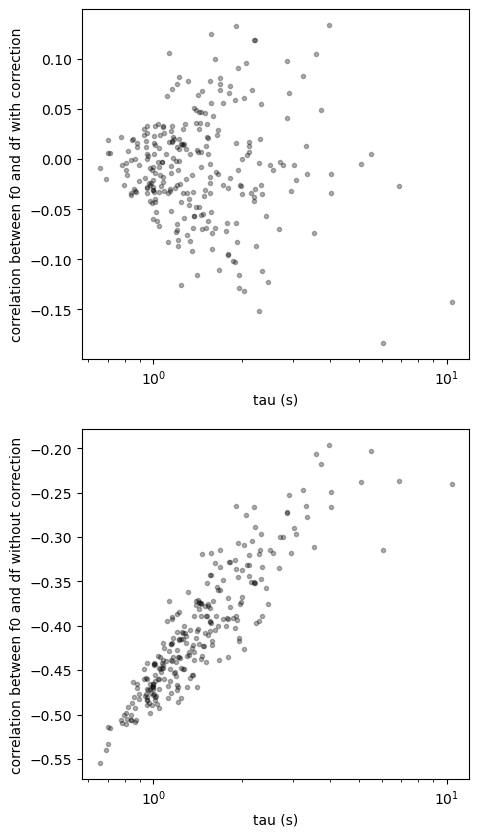

In [15]:


fig = plt.figure(figsize = [5,10])
ax1 = fig.add_subplot(2,1,1)
ax1.plot(photostim_data_dict[session]['fitted_tau'],photostim_data_dict[session]['dF_corr_vs_f0_corrcoef'],'k.',alpha = .3)
ax1.set_xlabel('tau (s)')
ax1.set_ylabel('correlation between f0 and df with correction')
ax1.set_xscale('log')

ax2 = fig.add_subplot(2,1,2)
ax2.plot(photostim_data_dict[session]['fitted_tau'],photostim_data_dict[session]['dF_vs_f0_corrcoef'] ,'k.',alpha = .3)
ax2.set_xlabel('tau (s)')
ax2.set_ylabel('correlation between f0 and df without correction')
ax2.set_xscale('log')

[-0.552319776968891, 0.1766613879867812]

Text(0, 0.5, 'correlation between f0 and df with correction')

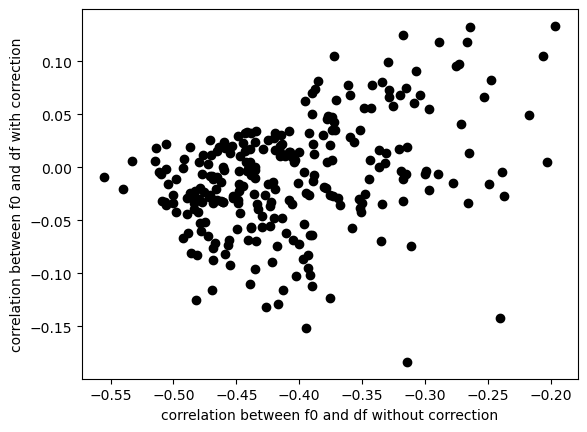

In [16]:
#with baseline correction
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(photostim_data_dict[session]['dF_vs_f0_corrcoef'],photostim_data_dict[session]['dF_corr_vs_f0_corrcoef'],'ko')
ax.set_xlabel('correlation between f0 and df without correction')
ax.set_ylabel('correlation between f0 and df with correction')
# lims = np.asarray([ax.get_xlim(),ax.get_ylim()])

# ax.set_ylim([np.min(lims),np.max(lims)])
# ax.set_xlim([np.min(lims),np.max(lims)])

TypeError: 'tuple' object is not callable

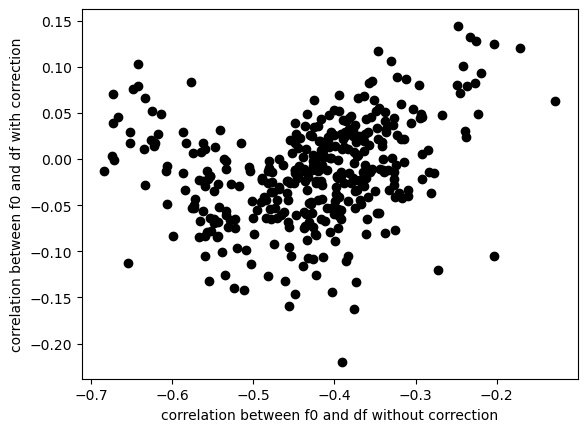

In [306]:
# before baseline correction
plt.plot(dF_vs_f0_corrcoef,dF_corr_vs_f0_corrcoef,'ko')


plt.xlabel('correlation between f0 and df without correction')
plt.ylabel('correlation between f0 and df with correction')
xlim = plt.xlim()
plt.ylim([0,1])

In [101]:
np.nanmean(dfs[:half])

0.22301303804506634

In [30]:
# create random halves of each session, and creates average amplitudes
# create deconvolved amplitudes as well - TODO
for session in photostim_data_dict.keys():
    mean_dspikes = []
    mean_dspikes_1 = []
    mean_dspikes_2 = []
    mean_df = []
    mean_impact = []
    mean_impact_1 = []
    mean_impact_2 = []
    mean_df_1 = []
    mean_df_2 = []
    mean_df_corr = []
    mean_impact_corr = []
    mean_df_corr_1 = []
    mean_df_corr_2 = []
    mean_impact_corr_1 = []
    mean_impact_corr_2 = []
    mean_f_start = []
    for f_start,df,df_corr,f0,percentiles,percentiles_corr in zip(photostim_data_dict[session]['F_start'],
                                                                  photostim_data_dict[session]['dF'],
                                                                  photostim_data_dict[session]['dF_corr'],
                                                                  photostim_data_dict[session]['fitted_f0'],
                                                                  photostim_data_dict[session]['cell_percentile_amplitudes_ALL'],
                                                                  photostim_data_dict[session]['cell_percentile_amplitudes_corrected_ALL']): #'F0'#'fitted_f0
        mean_dspikes_cell = []
        mean_dspikes_cell_1 = []
        mean_dspikes_cell_2 = []
        mean_df_cell = []
        mean_impact_cell = []
        mean_df_cell_1 = []
        mean_df_cell_2 = []
        mean_impact_cell_1 = []
        mean_impact_cell_2 = []
        mean_df_corr_cell = []
        mean_impact_corr_cell = []
        mean_df_corr_cell_1 = []
        mean_df_corr_cell_2 = []
        mean_impact_corr_cell_1 = []
        mean_impact_corr_cell_2 = []
        mean_f_start_cell = []
        F_range = np.asarray(percentiles)[95] - np.asarray(percentiles)[5]
        F_range_corr = np.asarray(percentiles_corr)[95] - np.asarray(percentiles_corr)[5]
        for group_i in range(len(f_start)):
            random_order = np.arange(len(df[group_i]))
            random.shuffle(random_order)
            mean_df_cell.append(np.nanmean(df[group_i])/f0)
            impacts = (df[group_i]-percentiles[50])/f0#percentiles[50]#/f0#F_range
            mean_impact_cell.append(np.nanmean(impacts))
            dfs = df[group_i]/f0
            dfs = dfs[random_order]
            impacts = impacts[random_order]
            half = int(len(dfs)/2)
            mean_df_cell_1.append(np.nanmean(dfs[:half]))
            mean_df_cell_2.append(np.nanmean(dfs[half:]))
            mean_impact_cell_1.append(np.nanmean(impacts[:half]))
            mean_impact_cell_2.append(np.nanmean(impacts[half:]))
            mean_df_corr_cell.append(np.nanmean(df_corr[group_i])/f0)
            impacts_corr = (df_corr[group_i]-percentiles[50])/f0#percentiles[50]#f0#F_range_corr
            
            mean_impact_corr_cell.append(np.nanmean(impacts_corr))
            dfs = df_corr[group_i]/f0
            dfs = dfs[random_order]
            impacts_corr = impacts[random_order]
            half = int(len(dfs)/2)
            mean_df_corr_cell_1.append(np.nanmean(dfs[:half]))
            mean_df_corr_cell_2.append(np.nanmean(dfs[half:]))
            mean_impact_corr_cell_1.append(np.nanmean(impacts_corr[:half]))
            mean_impact_corr_cell_2.append(np.nanmean(impacts_corr[half:]))
            mean_f_start_cell.append(np.nanmean(f_start[group_i])/f0)
        mean_df.append(mean_df_cell)
        mean_impact.append(mean_impact_cell)
        mean_df_1.append(mean_df_cell_1)
        mean_df_2.append(mean_df_cell_2)
        mean_impact_1.append(mean_impact_cell_1)
        mean_impact_2.append(mean_impact_cell_2)
        mean_df_corr.append(mean_df_corr_cell)
        mean_impact_corr.append(mean_impact_corr_cell)
        mean_df_corr_1.append(mean_df_corr_cell_1)
        mean_df_corr_2.append(mean_df_corr_cell_2)
        mean_impact_corr_1.append(mean_impact_corr_cell_1)
        mean_impact_corr_2.append(mean_impact_corr_cell_2)
        mean_f_start.append(mean_f_start_cell)
    photostim_data_dict[session]['mean_df'] = mean_df
    photostim_data_dict[session]['mean_impact'] = mean_impact
    photostim_data_dict[session]['mean_df_1st_half'] = mean_df_1
    photostim_data_dict[session]['mean_df_2nd_half'] = mean_df_2
    photostim_data_dict[session]['mean_impact_1st_half'] = mean_impact_1
    photostim_data_dict[session]['mean_impact_2nd_half'] = mean_impact_2
    photostim_data_dict[session]['mean_df_corr'] = mean_df_corr
    photostim_data_dict[session]['mean_impact_corr'] = mean_impact_corr
    photostim_data_dict[session]['mean_df_corr_1st_half'] = mean_df_corr_1
    photostim_data_dict[session]['mean_df_corr_2nd_half'] = mean_df_corr_2
    photostim_data_dict[session]['mean_impact_corr_1st_half'] = mean_impact_corr_1
    photostim_data_dict[session]['mean_impact_corr_2nd_half'] = mean_impact_corr_2
    photostim_data_dict[session]['mean_f_start'] = mean_f_start
    

    
distances_matrix = []
for group_idx in range(len(photostim_groups['groups'])):
    distances = []
    for s in stat:
        d_now = np.sqrt((photostim_groups['groups'][group_idx]['centerXY'][:,0]-s['med'][1])**2 + (photostim_groups['groups'][group_idx]['centerXY'][:,1] -s['med'][0])**2)
        distances.append(np.min(d_now))
    distances_matrix.append(distances)
    

In [82]:
df_1

array([nan, nan, nan, ..., nan, nan, nan])

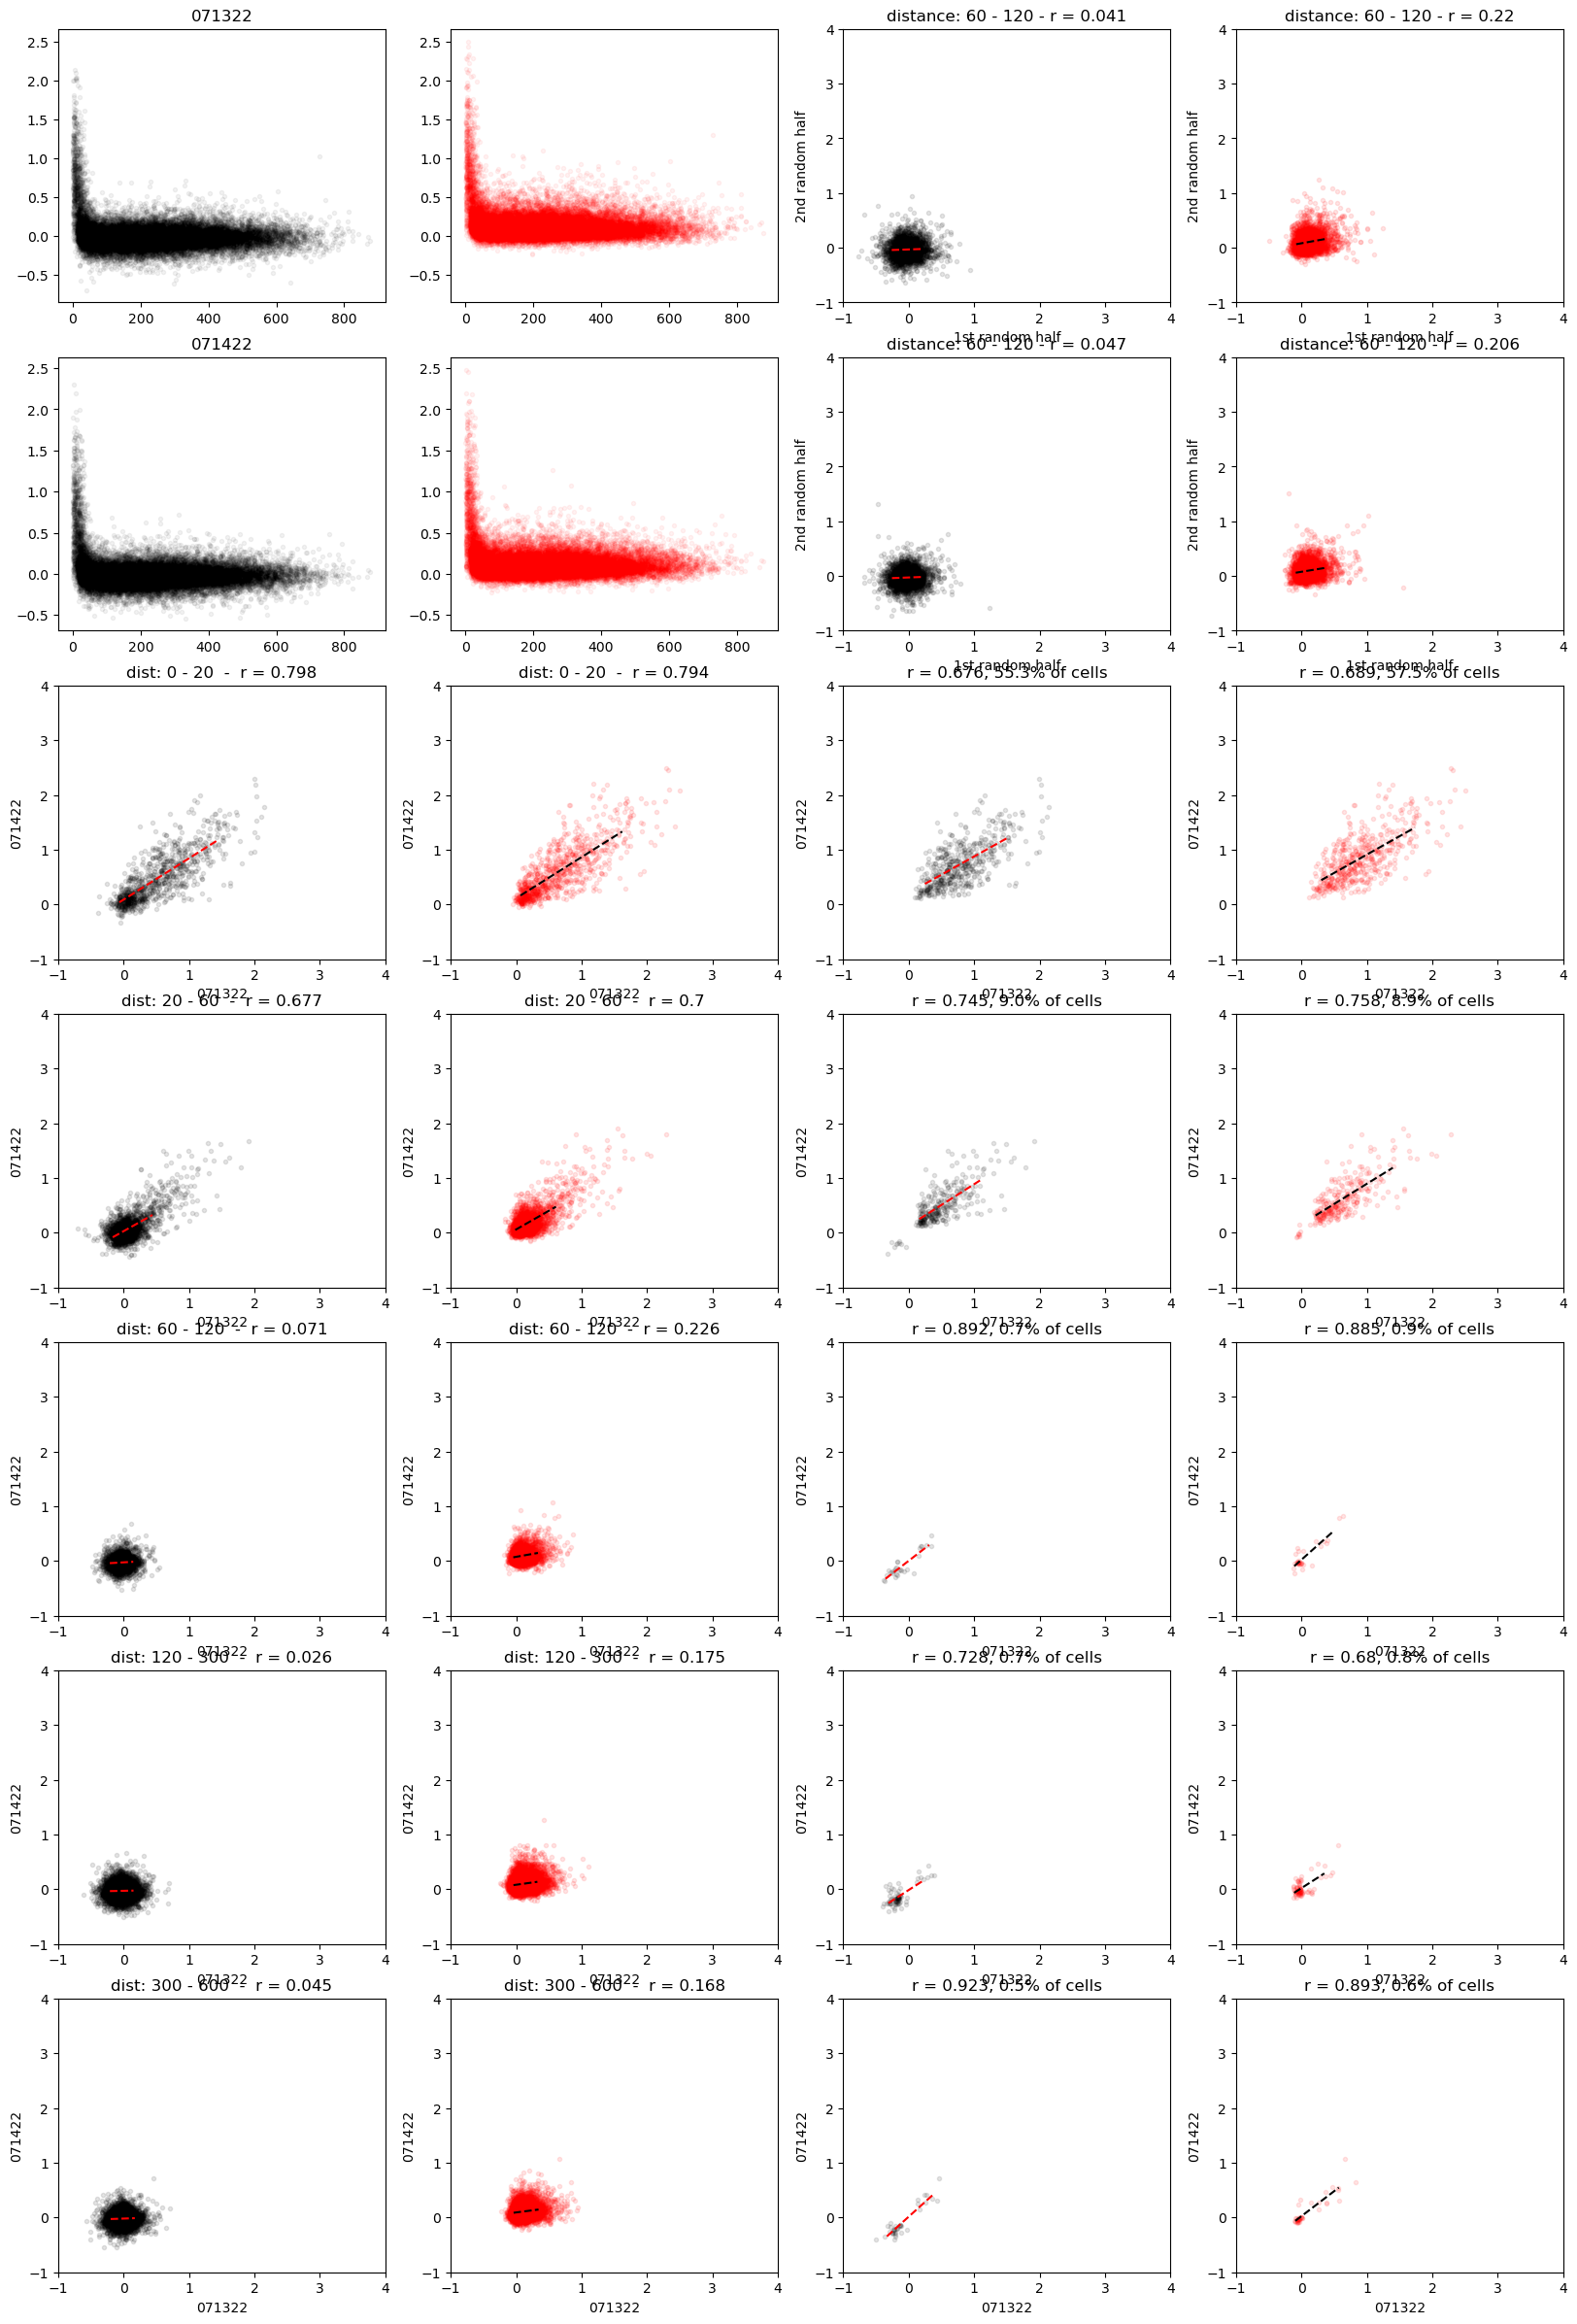

In [33]:

to_show = 'mean_df'#mean_impact#mean_df

fig = plt.figure(figsize = [20, 30])
pval = .05 
threshold = 333 # HOTFIX - absolute dF values above this value will be thrown out (noise) - have to fix this earlier in the analysis
tau_thresholds = [.5,5]
sessions_to_compare = ['071322','071422']#[
df_list = []
df_corr_list = []
tau_list = []
f0_list = []
min_dist_list = [0,20,60,120,300]
max_dist_list = [20,60,120,300,600]
limits = [-1,4]
plot_row_count = 2+len(min_dist_list)
min_dist = 60
max_dist = 120
minimum_time_constant = 0
for session_i in range(len(sessions_to_compare)):
    needed_cells = np.asarray(photostim_data_dict[session]['fitted_tau'])>minimum_time_constant
    session = sessions_to_compare[session_i]
    distances_flat = np.asarray(distances_matrix).T[needed_cells].flatten()
    df_flat = np.asarray(photostim_data_dict[session][to_show])[needed_cells].flatten()#mean_df#mean_impact
    df_corr_flat = np.asarray(photostim_data_dict[session][to_show+'_corr'])[needed_cells].flatten()#mean_df_corr#mean_impact_corr
    todel = (np.abs(df_flat)>threshold) | (np.abs(df_corr_flat)>threshold)
    df_flat[todel] = np.nan
    df_corr_flat[todel] = np.nan
    
    ax_distance_dependence = fig.add_subplot(plot_row_count,4,1+4*session_i)
    ax_distance_dependence.plot(distances_flat,df_flat,'k.',alpha = .05)
    ax_distance_dependence_corr = fig.add_subplot(plot_row_count,4,2+4*session_i,sharey = ax_distance_dependence)
    ax_distance_dependence_corr.plot(distances_flat,df_corr_flat,'r.',alpha = .05)
    ax_distance_dependence.set_title(session)
    
    needed = (distances_flat<max_dist) &(distances_flat>min_dist)
    
    ax_1st_second_half_nocorr = fig.add_subplot(plot_row_count,4,3+4*session_i)
    df_1 =  np.asarray(photostim_data_dict[session][to_show+'_1st_half'])[needed_cells].flatten()[needed]
    df_2 =  np.asarray(photostim_data_dict[session][to_show+'_2nd_half'])[needed_cells].flatten()[needed]
    ax_1st_second_half_nocorr.plot(df_1,df_2,'k.',alpha = .1)
    
    x = df_1
    y = df_2
    needed_ = (np.isnan(x)==False) & (np.isnan(y)==False)
    x = x[needed_]
    y = y[needed_]
    r = np.corrcoef(x,y)
    p = np.polyfit(x,y,1)
    xx = np.percentile(x,[5,95])
    yy = np.polyval(p,xx)
    ax_1st_second_half_nocorr.plot(xx,yy,'r--')
    ax_1st_second_half_nocorr.set_xlim(limits)
    ax_1st_second_half_nocorr.set_ylim(limits)
    ax_1st_second_half_nocorr.set_title('distance: {} - {} - r = {}'.format(min_dist,max_dist,np.round(r[1][0],3)))
    ax_1st_second_half_nocorr.set_xlabel('1st random half')
    ax_1st_second_half_nocorr.set_ylabel('2nd random half')
    
    ax_1st_second_half_corr = fig.add_subplot(plot_row_count,4,4+4*session_i)
    df_1 =  np.asarray(photostim_data_dict[session][to_show+'_corr_1st_half'])[needed_cells].flatten()[needed]
    df_2 =  np.asarray(photostim_data_dict[session][to_show+'_corr_2nd_half'])[needed_cells].flatten()[needed]
    ax_1st_second_half_corr.plot(df_1,df_2,'r.',alpha = .1)
    
    
    x = df_1
    y = df_2
    needed_ = (np.isnan(x)==False) & (np.isnan(y)==False)
    x = x[needed_]
    y = y[needed_]
    r = np.corrcoef(x,y)
    p = np.polyfit(x,y,1)
    xx = np.percentile(x,[5,95])
    yy = np.polyval(p,xx)
    ax_1st_second_half_corr.plot(xx,yy,'k--')
    ax_1st_second_half_corr.set_xlim(limits)
    ax_1st_second_half_corr.set_ylim(limits)
    ax_1st_second_half_corr.set_title('distance: {} - {} - r = {}'.format(min_dist,max_dist,np.round(r[1][0],3)))
    ax_1st_second_half_corr.set_xlabel('1st random half')
    ax_1st_second_half_corr.set_ylabel('2nd random half')

#     ax_corr_vs_noncorr = fig.add_subplot(plot_row_count,4,3+4*session_i)

#     ax_corr_vs_noncorr.plot(df_flat[needed],df_corr_flat[needed],'k.',alpha = .1)
#     ax_corr_vs_noncorr.set_title('distance: {} - {}'.format(min_dist,max_dist))
#     ax_corr_vs_noncorr.set_xlim(limits)
#     ax_corr_vs_noncorr.set_ylim(limits)
    
    
    df_list.append(df_flat[needed])
    df_corr_list.append(df_corr_flat[needed])
    f0_list.append(photostim_data_dict[session]['fitted_f0'])
    tau_list.append(photostim_data_dict[session]['fitted_tau'])
for only_significant_connections in [False,True]:
    for i,(min_dist,max_dist) in enumerate(zip(min_dist_list,max_dist_list)):
        needed_cells = np.min(np.asarray(tau_list),0)>minimum_time_constant
        df_list = []
        df_corr_list = []
        percentiles_list = []
        percentiles_corr_list = []
        for session_i in range(len(sessions_to_compare)):
            session = sessions_to_compare[session_i]
            percentiles_list.append(np.asarray(photostim_data_dict[session]['percentile'])[needed_cells].flatten())
            percentiles_corr_list.append(np.asarray(photostim_data_dict[session]['percentile_corr'])[needed_cells].flatten())
        for session_i in range(len(sessions_to_compare)):
            session = sessions_to_compare[session_i]
            distances_flat = np.asarray(distances_matrix).T[needed_cells].flatten()
            df_flat = np.asarray(photostim_data_dict[session][to_show])[needed_cells].flatten()#mean_df#mean_impact
            df_corr_flat = np.asarray(photostim_data_dict[session][to_show+'_corr'])[needed_cells].flatten()#mean_df_corr#mean_impact_corr
            todel = (np.abs(df_flat)>threshold) | (np.abs(df_corr_flat)>threshold)
            df_flat[todel] = np.nan
            df_corr_flat[todel] = np.nan
            if only_significant_connections:
                needed = (distances_flat<max_dist) &(distances_flat>min_dist) & ((np.nanmax(percentiles_list,0)<pval) | (np.nanmin(percentiles_list,0)>1-pval))
                needed_all = (distances_flat<max_dist) &(distances_flat>min_dist)
                needed_corr = (distances_flat<max_dist) &(distances_flat>min_dist) & ((np.nanmax(percentiles_corr_list,0)<pval) | (np.nanmin(percentiles_corr_list,0)>1-pval))
            else:
                needed = (distances_flat<max_dist) &(distances_flat>min_dist)
                needed_corr = (distances_flat<max_dist) &(distances_flat>min_dist)
            
            df_list.append(df_flat[needed])
            df_corr_list.append(df_corr_flat[needed_corr])
        if only_significant_connections:
            ax_d1d2 = fig.add_subplot(plot_row_count,4,11+4*i)
        else:
            ax_d1d2 = fig.add_subplot(plot_row_count,4,9+4*i)
        ax_d1d2.plot(df_list[0],df_list[1],'k.',alpha = .1)
        x = df_list[0]
        y = df_list[1]
        needed = (np.isnan(x)==False) & (np.isnan(y)==False)
        x = x[needed]
        y = y[needed]
        r = np.corrcoef(x,y)
        p = np.polyfit(x,y,1)
        xx = np.percentile(x,[5,95])
        yy = np.polyval(p,xx)
        ax_d1d2.plot(xx,yy,'r--')
        if only_significant_connections:
            ax_d1d2.set_title('r = {}, {:.1f}% of cells'.format(np.round(r[1][0],3),np.sum(needed)/np.sum(needed_all)*100))
        else:
            ax_d1d2.set_title('dist: {} - {}  -  r = {}'.format(min_dist,max_dist,np.round(r[1][0],3)))
        ax_d1d2.set_xlabel(sessions_to_compare[0])
        ax_d1d2.set_ylabel(sessions_to_compare[1])
        if only_significant_connections:
            ax_d1d2_corr = fig.add_subplot(plot_row_count,4,12+4*i,sharex = ax_d1d2,sharey = ax_d1d2)
        else:
            ax_d1d2_corr = fig.add_subplot(plot_row_count,4,10+4*i,sharex = ax_d1d2,sharey = ax_d1d2)
        ax_d1d2_corr.plot(df_corr_list[0],df_corr_list[1],'r.',alpha = .1)
        x = df_corr_list[0]
        y = df_corr_list[1]
        needed = (np.isnan(x)==False) & (np.isnan(y)==False)
        x = x[needed]
        y = y[needed]
        r = np.corrcoef(x,y)
        p = np.polyfit(x,y,1)
        xx = np.percentile(x,[5,95])
        yy = np.polyval(p,xx)
        ax_d1d2_corr.plot(xx,yy,'k--')
        if only_significant_connections:
            ax_d1d2_corr.set_title('r = {}, {:.1f}% of cells'.format(np.round(r[1][0],3),np.sum(needed_corr)/np.sum(needed_all)*100))
        else:
            ax_d1d2_corr.set_title('dist: {} - {}  -  r = {}'.format(min_dist,max_dist,np.round(r[1][0],3)))

        ax_d1d2_corr.set_xlim(limits)
        ax_d1d2_corr.set_ylim(limits)
        ax_d1d2_corr.set_xlabel(sessions_to_compare[0])
        ax_d1d2_corr.set_ylabel(sessions_to_compare[1])



array([[-0.16445979, -0.14455899, -0.13120159, ...,  0.25946628,
         0.30062995,  0.58811185],
       [-0.07511163, -0.05731312, -0.04783521, ...,  0.12419101,
         0.13884926,  0.22474465],
       [-0.10968307, -0.08983315, -0.07278961, ...,  0.28340249,
         0.30976853,  0.41432671],
       ...,
       [-0.08015852, -0.06252617, -0.05507269, ...,  0.23252555,
         0.2577035 ,  0.39423532],
       [-0.02971696, -0.00995535,  0.00290858, ...,  0.32734484,
         0.35402166,  0.52009787],
       [-0.03644259, -0.01869179, -0.00807484, ...,  0.2753556 ,
         0.29415694,  0.37329552]])

In [194]:
np.percentile(hists[:,0],95)

-0.008870183279724901

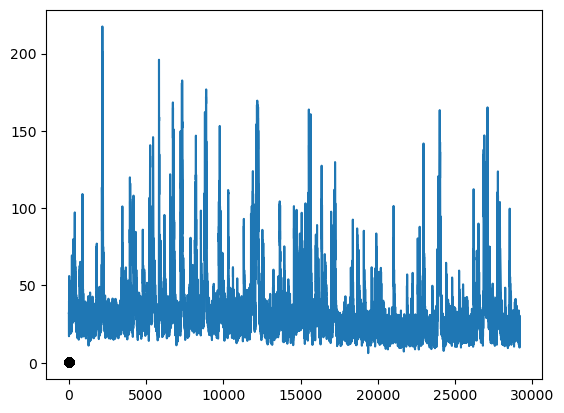

In [196]:
plt.plot(hists[:,0],hists[:,95]-hists[:,5],'ko')
idx = np.argmin(np.abs(hists[:,0]-np.percentile(hists[:,0],5)))
plt.plot(F_photostim[idx,:])

In [19]:
fig = plt.figure()
ax_tau_minval = fig.add_subplot(2,1,1)
hists = (np.asarray(photostim_data_dict[session]['cell_percentile_amplitudes_corrected_ALL'])/np.asarray(photostim_data_dict[session]['fitted_f0'])[:,np.newaxis])
#min_percentiles = 
for f0,tau,line in zip(np.asarray(photostim_data_dict[session]['fitted_f0']),np.asarray(photostim_data_dict[session]['fitted_tau']),hists):
    #plt.plot(line,alpha = .2)
    ax_tau_minval.plot(tau,line[0],'ko')
plt.xscale('log')

SyntaxError: invalid syntax (2626997631.py, line 4)

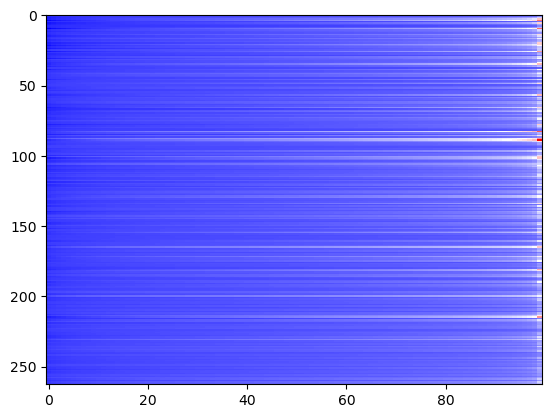

In [145]:

im = plt.imshow(np.asarray(photostim_data_dict[session]['cell_percentile_amplitudes_corrected_ALL']),aspect = 'auto',interpolation='none')
#im.set_clim([-5, 5])

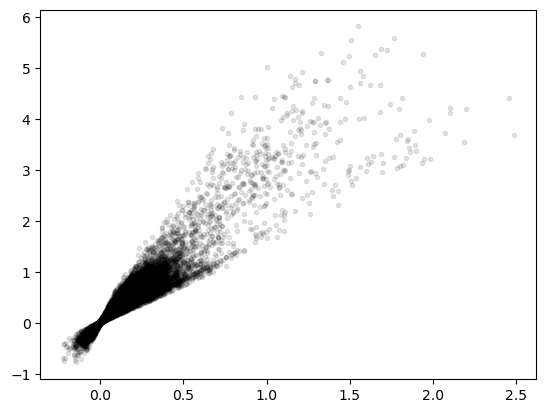

In [22]:
plt.plot(np.asarray(photostim_data_dict[session]['mean_df_corr']).flatten(),np.asarray(photostim_data_dict[session]['mean_impact_corr']).flatten(),'k.',alpha = .1)

Text(0.5, 1.0, '(-1.0, 0.9995)')

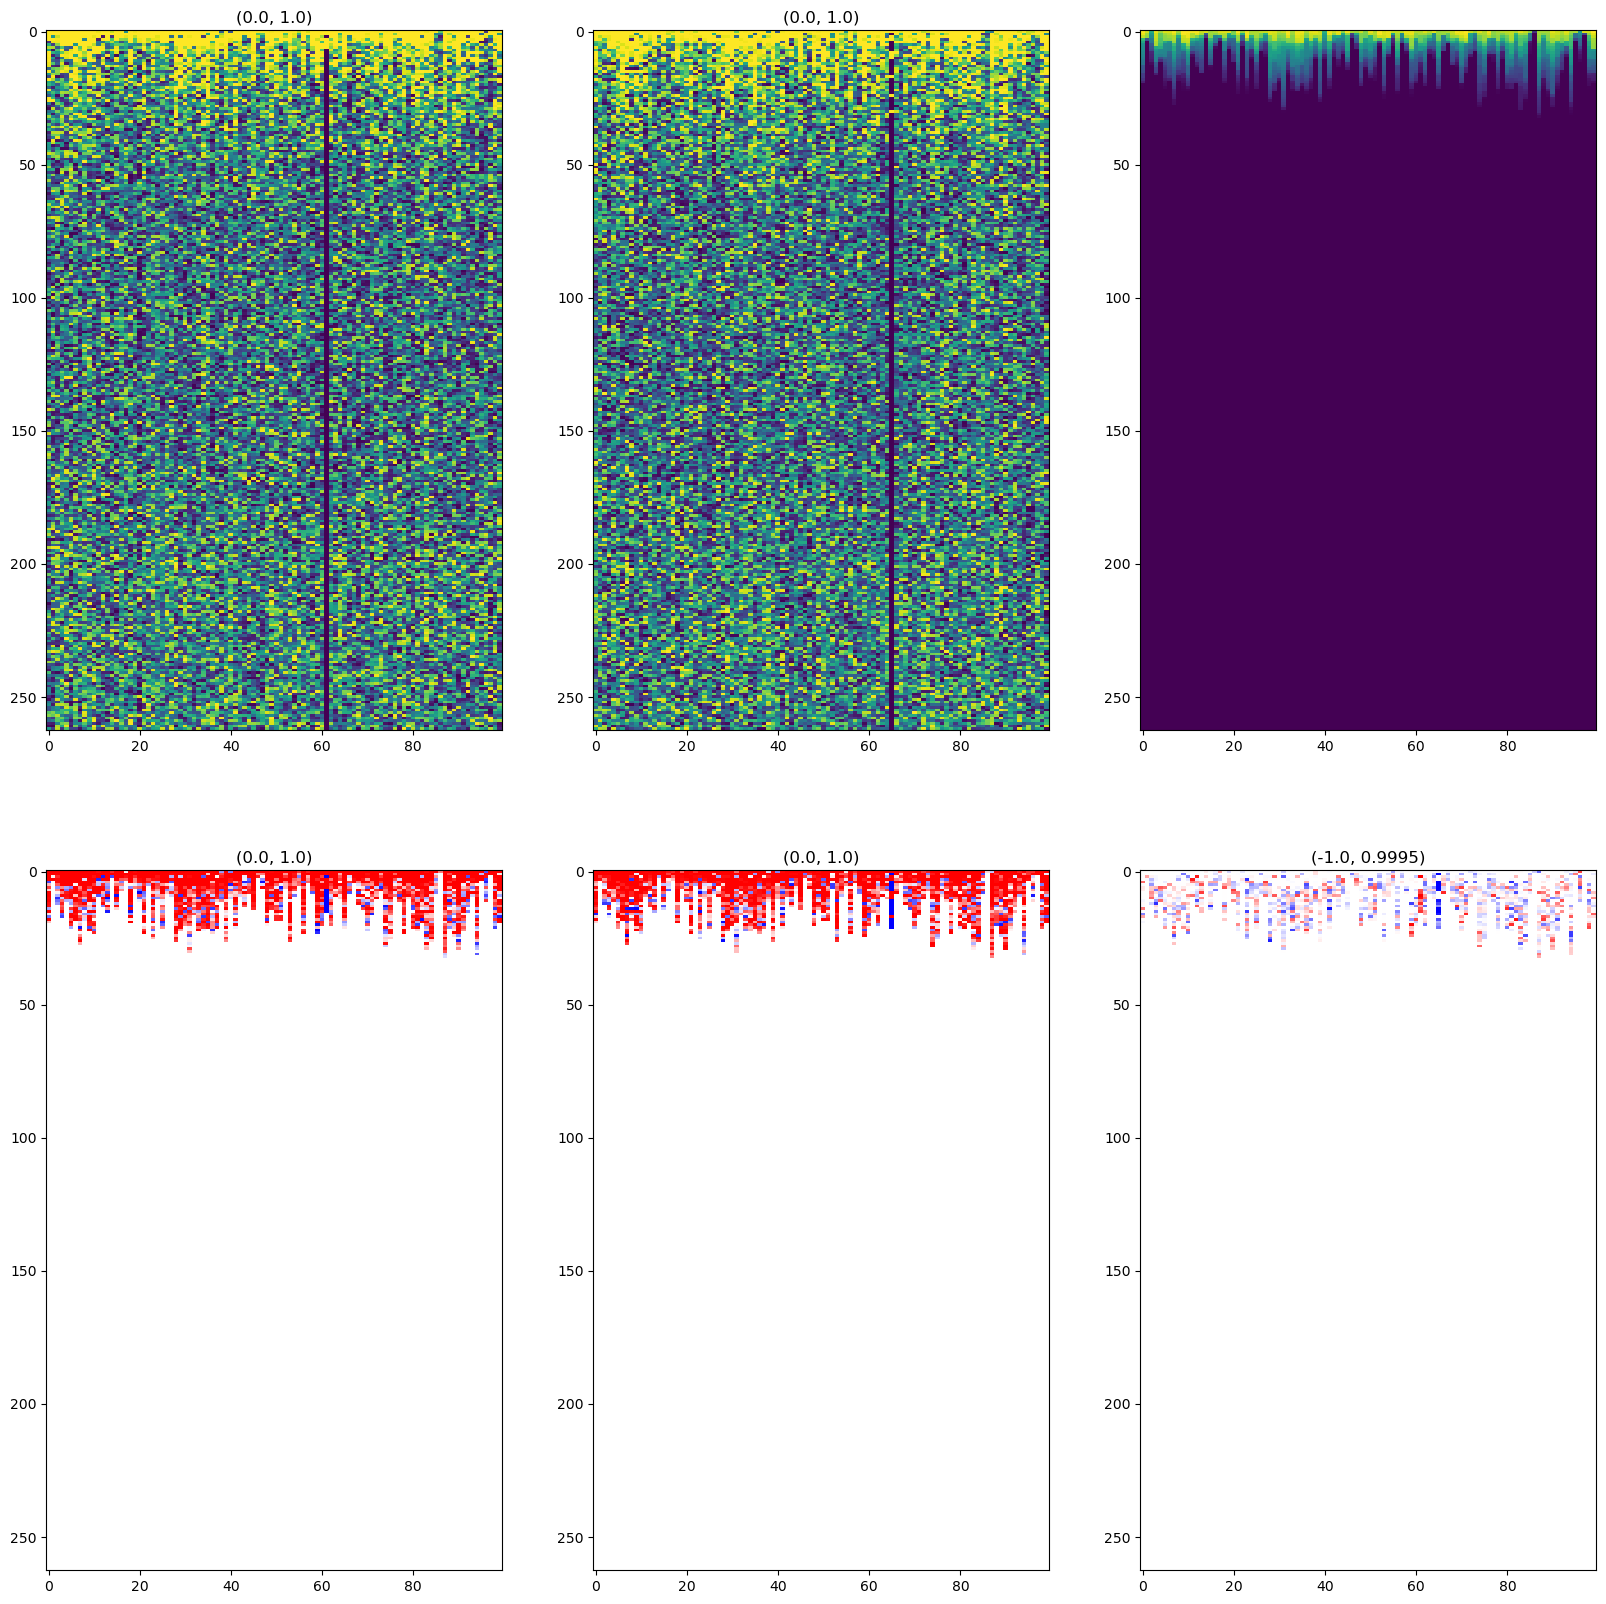

In [34]:
distance_offset = 30
reorder_by_distance = True
value_to_plot = 'percentile_corr'#'mean_df_corr'#'mean_df'#'mean_impact'#'percentile_corr'#mean_impact_corr
dist_matrix = np.asarray(distances_matrix).copy()
dist_matrix[dist_matrix>distance_offset] = distance_offset
dist_matrix = distance_offset-dist_matrix
fig = plt.figure(figsize = [20,20])
dist_matrix_list = []
limits = [0,1]
for i,session in enumerate(sessions):
    plt.set_cmap('viridis')
    ax = fig.add_subplot(2,3,1+i)
    if reorder_by_distance:
        matrix_to_plot = np.asarray(photostim_data_dict[session][value_to_plot])
        for group_i,group_dists in enumerate(np.asarray(distances_matrix)):
            order = np.argsort(group_dists)
            matrix_to_plot[:,group_i]=matrix_to_plot[order,group_i]

    else:
        matrix_to_plot = np.asarray(photostim_data_dict[session][value_to_plot])
    im = ax.imshow(matrix_to_plot,aspect = 'auto',interpolation='none')
    im.set_clim(limits)
    ax.set_title(im.get_clim())
    ax = fig.add_subplot(2,3,4+i)
    conns = np.asarray(photostim_data_dict[session][value_to_plot]).copy()
    conns[dist_matrix.T == 0 ] = np.nan
    if reorder_by_distance:
        matrix_to_plot = conns
        for group_i,group_dists in enumerate(np.asarray(distances_matrix)):
            order = np.argsort(group_dists)
            matrix_to_plot[:,group_i]=matrix_to_plot[order,group_i]
        conns = matrix_to_plot
    plt.set_cmap('bwr')
    im = ax.imshow(conns,aspect = 'auto',interpolation='none')
    im.set_clim(limits)
    dist_matrix_list.append(conns)
    ax.set_title(im.get_clim())
    
plt.set_cmap('viridis')  
ax_dist = fig.add_subplot(2,3,3)
if reorder_by_distance:
    matrix_to_plot = dist_matrix.T
    for group_i,group_dists in enumerate(np.asarray(distances_matrix)):
        order = np.argsort(group_dists)
        matrix_to_plot[:,group_i]=matrix_to_plot[order,group_i]
    conns = matrix_to_plot
ax_dist.imshow(matrix_to_plot,aspect = 'auto',interpolation='none')
plt.set_cmap('bwr')
ax_difi = fig.add_subplot(2,3,6)
dif_matrix = dist_matrix_list[1]-dist_matrix_list[0]
#dif_matrix[dist_matrix.T == 0 ] = np.nan
im = ax_difi.imshow(dif_matrix,aspect = 'auto',interpolation='none')
#im.set_clim([-1,1])
ax_difi.set_title(im.get_clim())

In [167]:
i


262

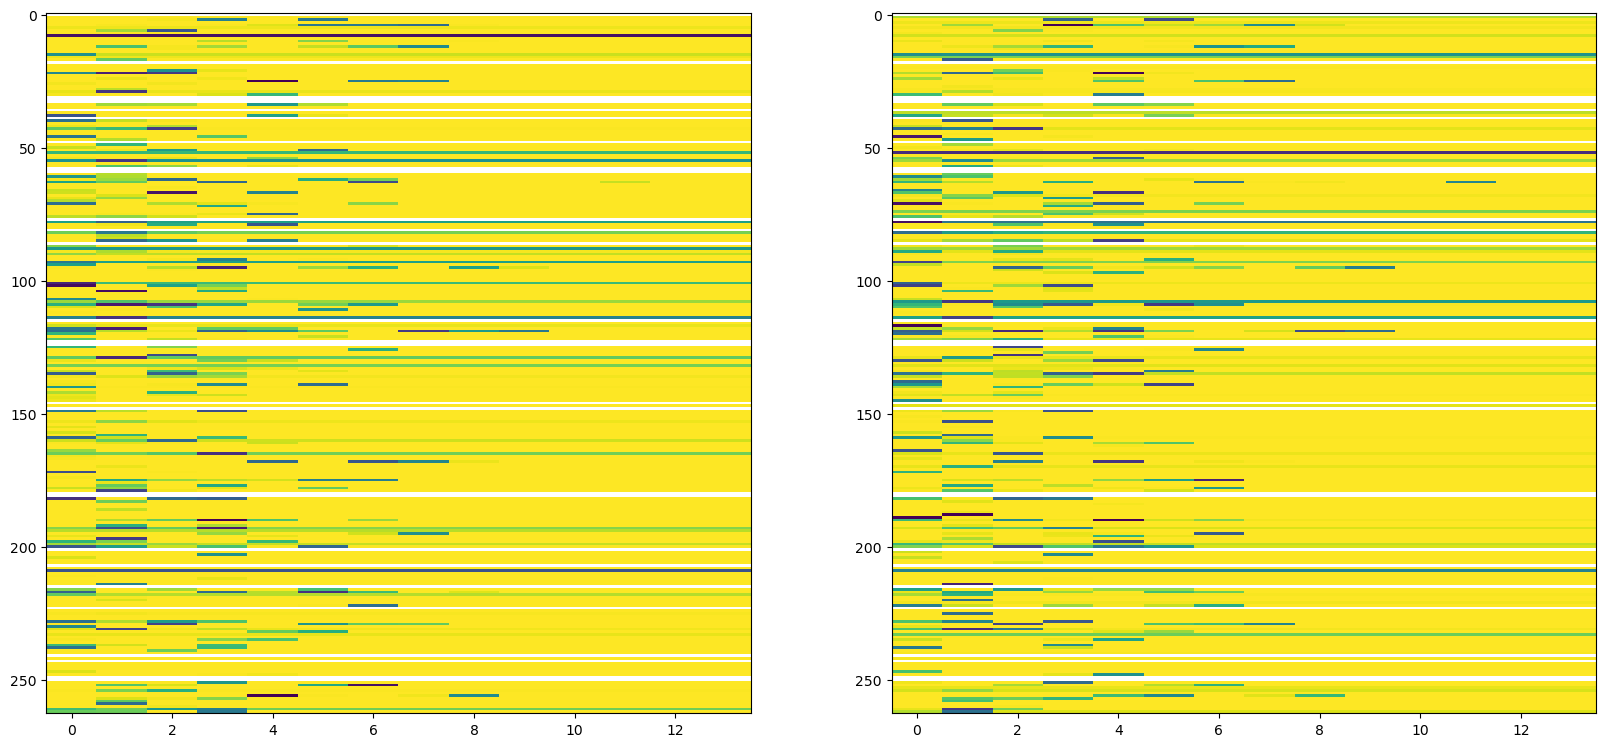

In [43]:
# collect all the direct photostim groups for each cell and look at the responses - is there a non-stimulatable cell?
distance_offset = 20
dist_matrix = np.asarray(distances_matrix).copy()
dist_matrix[dist_matrix>distance_offset] = distance_offset
dist_matrix = distance_offset-dist_matrix

fig = plt.figure(figsize = [20,20])
for i,session in enumerate(sessions):
    conns = np.asarray(photostim_data_dict[session]['percentile_corr']).T.copy()
    conns[dist_matrix == 0 ] = np.nan
    probs_per_cell = []
    non_nan_num = []
    for c in conns.T:
        non_nans = np.isnan(c)== False
        probs_per_cell.append(c[non_nans])
        non_nan_num.append(sum(non_nans))
    colnum = np.max(non_nan_num)+1
    stim_matrix = np.zeros([colnum,len(probs_per_cell)])*np.nan
    
    
    
    ax = fig.add_subplot(2,2,1+i)
    plt.set_cmap('viridis')
    for i,p in enumerate(probs_per_cell):
        stim_matrix[:len(p),i] = p
        try:
            stim_matrix[len(p):,i] = np.nanmax(p)
        except:
            pass
    
    
    
    
    im = ax.imshow(stim_matrix.T,aspect = 'auto',interpolation='none')
    im.set_clim([0,1])
   # adsa
    

Text(0.5, 0, 'F0 fold-difference 071422/071322')

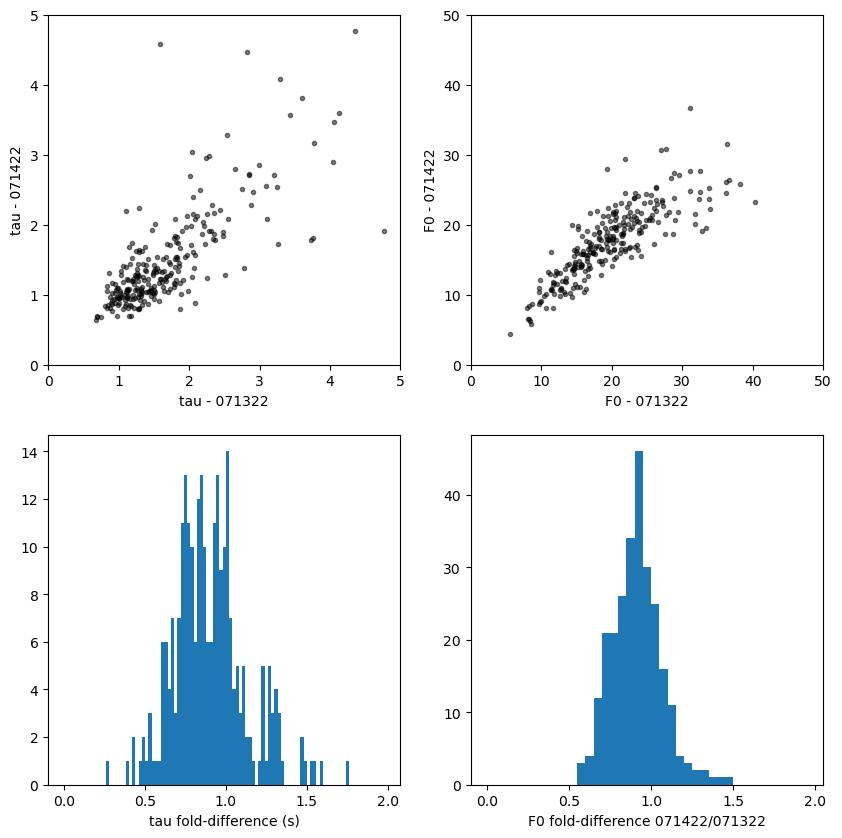

In [44]:
fig = plt.figure(figsize = [10,10])
ax_tau = fig.add_subplot(2,2,1)
ax_tau.plot(tau_list[0],tau_list[1],'k.',alpha = .5)
ax_tau.set_xlabel('tau - {}'.format(sessions_to_compare[0]))
ax_tau.set_ylabel('tau - {}'.format(sessions_to_compare[1]))
ax_tau.set_xlim([0,5])
ax_tau.set_ylim([0,5])
ax_tau_diff = fig.add_subplot(2,2,3)
ax_tau_diff.hist(np.asarray(tau_list[1])/np.asarray(tau_list[0]),np.arange(0,2,.02))
ax_tau_diff.set_xlabel('tau fold-difference (s)')

ax_f0 = fig.add_subplot(2,2,2)
ax_f0.plot(f0_list[0],f0_list[1],'k.',alpha = .5)
ax_f0.set_xlabel('F0 - {}'.format(sessions_to_compare[0]))
ax_f0.set_ylabel('F0 - {}'.format(sessions_to_compare[1]))
ax_f0.set_xlim([0,50])
ax_f0.set_ylim([0,50])
ax_f0_diff = fig.add_subplot(2,2,4)
ax_f0_diff.hist(np.asarray(f0_list[1])/np.asarray(f0_list[0]),np.arange(0,2,.05))
ax_f0_diff.set_xlabel('F0 fold-difference {}/{}'.format(sessions_to_compare[1],sessions_to_compare[0]))

(-2.0, 2.0)

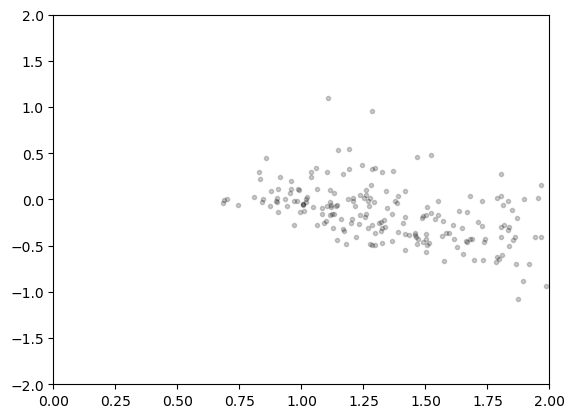

In [48]:
fig = plt.figure()
ax=fig.add_subplot(1,1,1)
ax.plot(np.asarray(tau_list[0]),np.asarray(tau_list[1])-np.asarray(tau_list[0]),'k.',alpha  = .2)
ax.set_xlim([0,2])
ax.set_ylim([-2,2])
# plt.yscale('log')
# plt.xscale('log')

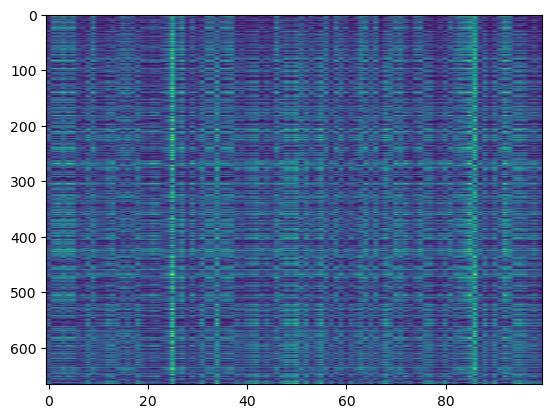

In [807]:
plt.imshow(np.asarray(distances_matrix).T,aspect = 'auto')

(-4.0, 8.0)

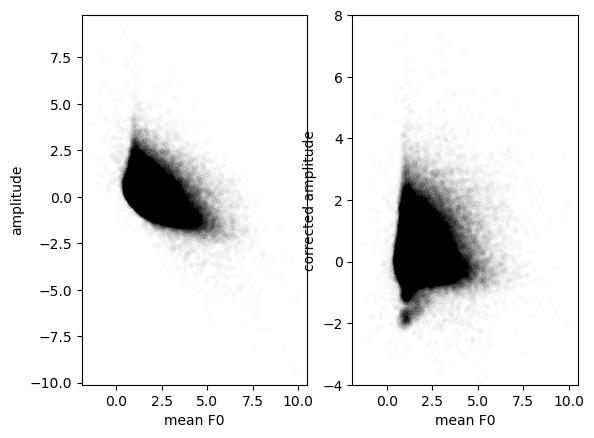

In [774]:
fig = plt.figure()
ax_ampl = fig.add_subplot(1,2,1)
ax_ampl.plot(np.concatenate(group_f0s_ALL),np.concatenate(group_amplitudes_ALL),'k.',alpha = .01)
ax_ampl.set_xlabel('mean F0')
ax_ampl.set_ylabel('amplitude')
ax_ampl_corr = fig.add_subplot(1,2,2)
ax_ampl_corr.plot(np.concatenate(group_f0s_ALL),np.concatenate(corrected_group_amplitudes_ALL),'k.',alpha = .01)
ax_ampl_corr.set_xlabel('mean F0')
ax_ampl_corr.set_ylabel('corrected amplitude')
ax_ampl_corr.set_ylim([-4,8])

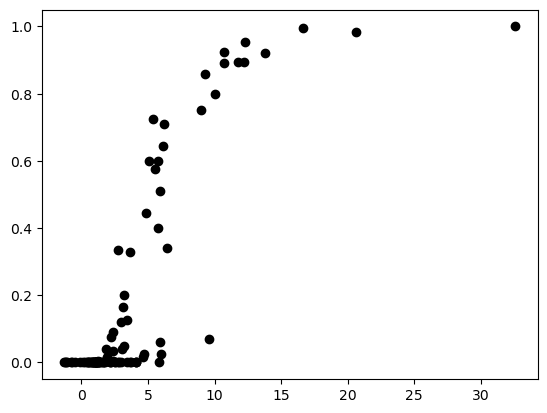

In [676]:

corrected_group_mean_amplitudes = []
for g in corrected_group_amplitudes_all:
    corrected_group_mean_amplitudes.append(np.nanmean(g))
plt.plot(corrected_group_mean_amplitudes,group_percentiles,'ko')

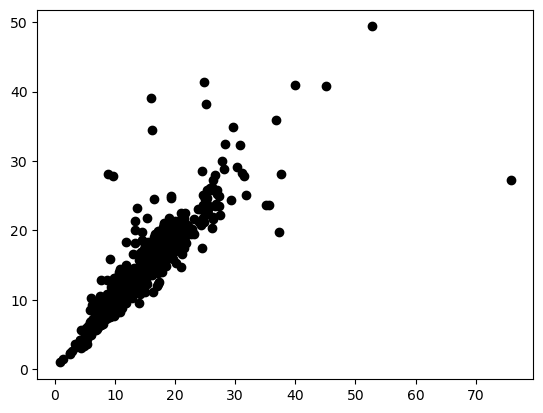

In [599]:
# calculated_taus_session = calculated_taus
# calculated_f0s_session = calculated_f0s
# calculated_taus_photostim = calculated_taus
# calculated_f0s_photostim = calculated_f0s
plt.plot(calculated_f0s_session,calculated_f0s_photostim,'ko')

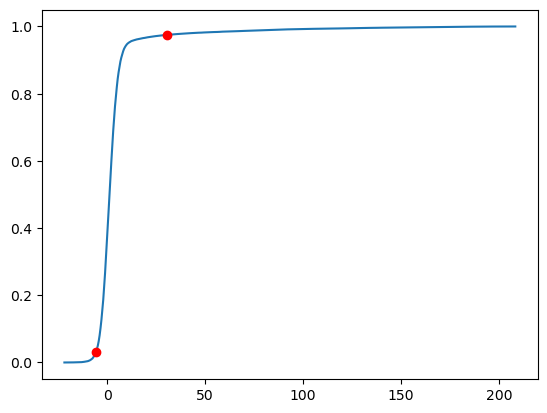

In [629]:
y,x = np.histogram(amplitudes_corrected,500)
x = np.mean([x[:-1],x[1:]],0)
pdf_y = np.cumsum(y)/np.sum(y)
idx_low = np.argmax(pdf_y>.025)
idx_high = np.argmax(pdf_y>.975)
plt.plot(x,pdf_y)
plt.plot(x[idx_low],pdf_y[idx_low],'ro')
plt.plot(x[idx_high],pdf_y[idx_high],'ro')

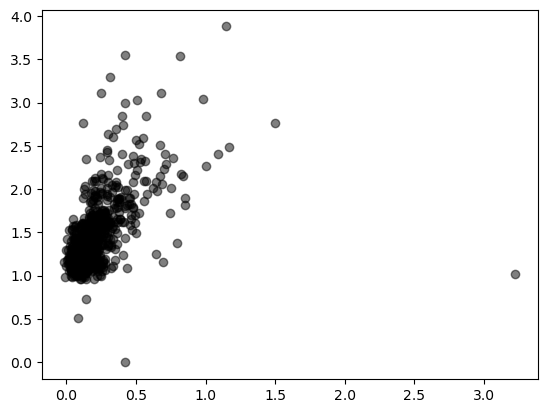

In [548]:
plt.plot(np.mean(dFF_photostim,1),calculated_taus,'ko',alpha = .5)

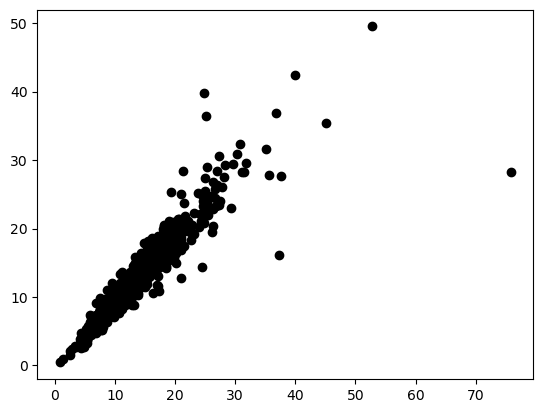

In [572]:
#plt.hist(1/np.asarray(calculated_taus),50)
plt.plot(calculated_f0s,F0_scalar_photostim,'ko')
#plt.plot(np.mean(dFF_photostim,1),-1*np.asarray(calculated_taus),'ko')

In [70]:
F_norm = (F_now-F0)/F0


(60, 30)

In [41]:
#mean_df[np.isnan(mean_df_corr)]  = 0
np.argsort(mean_df)

array([14, 41, 47, 98, 19, 17, 87, 99,  0, 71, 78, 54,  8, 57, 43, 28, 60,
       95, 27, 46, 10, 91, 12, 58, 21,  9, 44, 80, 77, 94, 74, 59, 67, 30,
       32, 18, 68, 73, 45, 93, 31, 25, 16, 51, 63, 24,  5, 38, 49, 66, 52,
       13, 70, 56, 50, 33, 11, 64, 34, 89, 88, 48, 35,  2, 97, 53, 84, 92,
       36,  3, 96, 65, 76, 55,  6,  1, 86, 26, 85, 90, 23, 20, 42, 75, 22,
       69, 62, 40, 39, 15, 81, 82,  7,  4, 37, 83, 29, 61, 72, 79])

photostim offset from trial start is 0 frames


Text(0.5, 1.0, 'cell 14 - group 79')

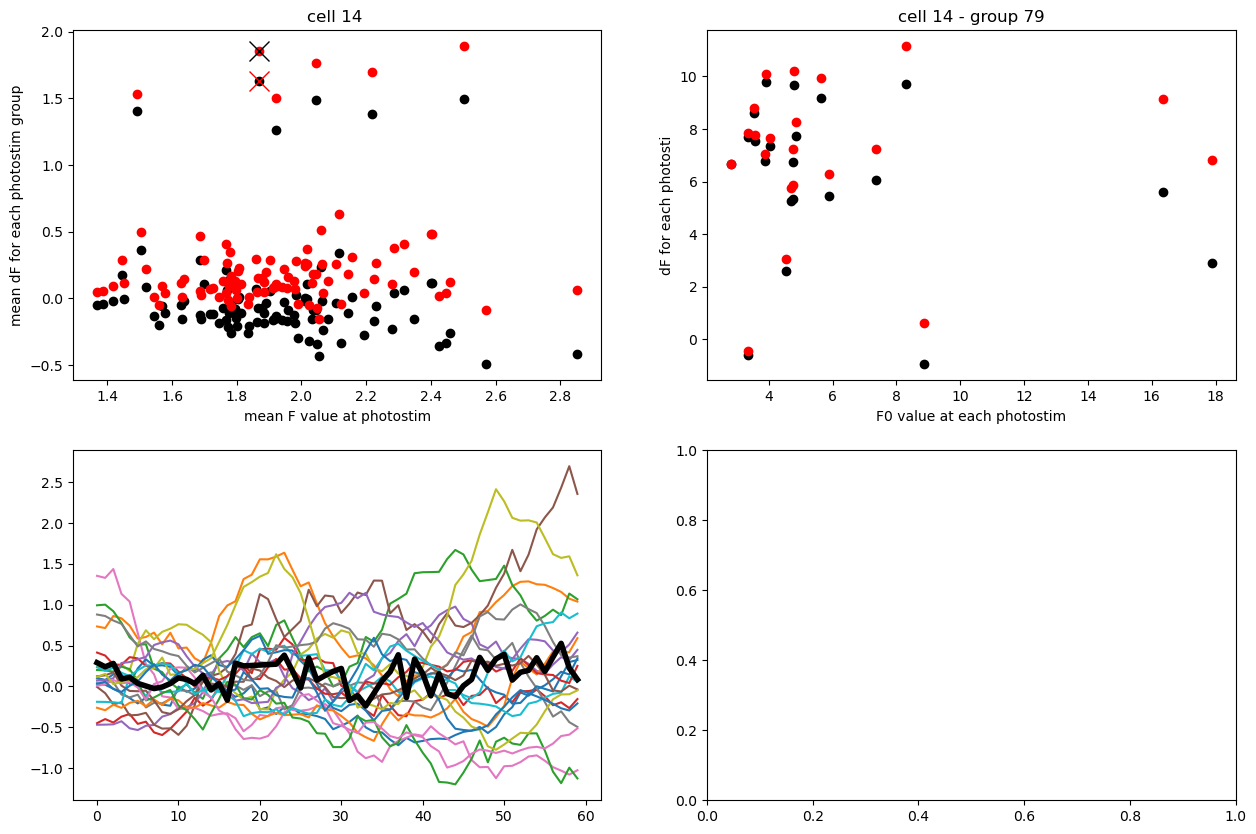

In [51]:
# show the F0 distribution of a given cell for different photostim groups
cell_idx_to_plot = 14
cell_idx = cell_idx_to_plot#2#16
group_idx = 79
session = '071422'

session_dir = os.path.join(suite2p_dir_base,setup,subject,fov,session)
photostim_dir = os.path.join(session_dir,'photostim')
photostim_groups = np.load(os.path.join(photostim_dir,'photostim_groups.npy'),allow_pickle=True).tolist()
ops =  np.load(os.path.join(photostim_dir,'ops.npy'),allow_pickle = True).tolist()
photostim_indices = np.concatenate([[0],np.cumsum(ops['frames_per_file'])])[:-1]
dFF_photostim,F_photostim,F0_photostim,F0_scalar_photostim,Fneu_photostim = load_and_calculate_dff(photostim_dir,
                                                                                    scalar_f0 = scalar_f0,
                                                                                    photostim = True,
                                                                                    correct_offset = correct_offset)

F_photostim_aligned = BCI_analysis.io_suite2p.align_trace_to_event(F_photostim,
                                                                   photostim_indices,
                                                                   step_back,
                                                                   step_forward)

F_now = F_photostim_aligned[:,cell_idx,np.asarray(photostim_groups['group_order'])==group_idx] # this has to be generated beforehand - 



mean_f0 = photostim_data_dict[session]['mean_f_start'][cell_idx]
mean_df = photostim_data_dict[session]['mean_df'][cell_idx]
mean_df_corr = photostim_data_dict[session]['mean_df_corr'][cell_idx]
f0 = photostim_data_dict[session]['F_start'][cell_idx][group_idx]
df = photostim_data_dict[session]['dF'][cell_idx][group_idx]
df_corr = photostim_data_dict[session]['dF_corr'][cell_idx][group_idx]
F0 = photostim_data_dict[session]['F0'][cell_idx]
fig = plt.figure(figsize = [15,10])
ax=fig.add_subplot(2,2,1)
ax_group=fig.add_subplot(2,2,2)
ax_group_traces = fig.add_subplot(2,2,3)
ax_spikes = fig.add_subplot(2,2,4)
F_norm = (F_now-F0)/F0
for F in (F_norm -np.mean(F_norm[baseline_offset:baseline_offset+baseline_length,:],0)).T:
    ax_group_traces.plot(BCI_analysis.pipeline_utils.rollingfun(F,10))
ax_group_traces.plot(np.mean(F_norm -np.mean(F_norm[baseline_offset:baseline_offset+baseline_length,:],0),1),'k-',linewidth = 4)
ax.plot(mean_f0,mean_df,'ko')
ax.plot(mean_f0,mean_df_corr,'ro')
# needed = np.asarray(connectivity)[:,cell_idx]<0
# ax.plot(mean_f0,np.asarray(amplitude_matrix)[needed,cell_idx],'bo')
# needed = np.asarray(connectivity)[:,cell_idx]>0
# ax.plot(mean_f0,np.asarray(amplitude_matrix)[needed,cell_idx],'ro')
# time_constant_t = calculated_taus[cell_idx] #s
# timeConstant = 1000 * time_constant_t / (50*offset_photostim) # change in 10 steps
# #amplitude = amplitude+np.nanmean(DFF_averaged[:10,:],0)/timeConstant
# f0_range = np.arange(0,np.max(mean_f0),.1)
# decay_range = f0_range/timeConstant*-1
# ax.plot(f0_range,decay_range,'r-',label = 'cell decay')
# time_constant_t_gcamp = 1.2 #s
# timeConstant = 1000 * time_constant_t_gcamp / (50*offset_photostim) # change in 10 steps
# decay_range = f0_range/timeConstant*-1
# ax.plot(f0_range,decay_range,'b-',label = 'gcamp decay')
# ax.legend()

ax.set_xlabel('mean F value at photostim')
ax.set_ylabel('mean dF for each photostim group')
ax.set_title('cell {} '.format(cell_idx))
ax.plot(mean_f0[group_idx],mean_df[group_idx],'rx',ms = 14,linewidth =6)
ax.plot(mean_f0[group_idx],mean_df_corr[group_idx],'kx',ms = 14,linewidth =6)

ax_group.plot((f0-F0)/F0,df/F0,'ko')
ax_group.plot((f0-F0)/F0,df_corr/F0,'ro')

# time_constant_t = calculated_taus[cell_idx] #s
# timeConstant = 1000 * time_constant_t / (50*10) # change in 10 steps
# f0_range = np.arange(0,np.max(f0_notaveraged[cell_idx,:]),.1)
# decay_range = f0_range/timeConstant*-1
# ax_group.plot(f0_range,decay_range,'r-',label = 'cell decay')
# time_constant_t_gcamp = 1.2 #s
# timeConstant = 1000 * time_constant_t_gcamp / (50*10) # change in 10 steps
# decay_range = f0_range/timeConstant*-1
# ax_group.plot(f0_range,decay_range,'b-',label = 'gcamp decay')
# ax_group.legend()


ax_group.set_xlabel('F0 value at each photostim')
ax_group.set_ylabel('dF for each photosti')
ax_group.set_title('cell {} - group {}'.format(cell_idx,group_idx))



# spikes_aligned = BCI_analysis.io_suite2p.align_trace_to_event(photostim_data_dict[session]['spikes'],
#                                                               photostim_indices,
#                                                               step_back,
#                                                               step_forward)

# F_now = spikes_aligned[:,cell_idx,np.asarray(photostim_groups['group_order'])==group_idx]
# for F in (F_now-np.mean(F_now[baseline_offset:baseline_offset+baseline_length,:],0)).T:
#     ax_spikes.plot(BCI_analysis.pipeline_utils.rollingfun(F,10))

# ax_spikes.plot(np.nanmean(F_now,1),'k-',linewidth = 4)#-np.mean(F_now[baseline_offset:baseline_offset+baseline_length,:],0)

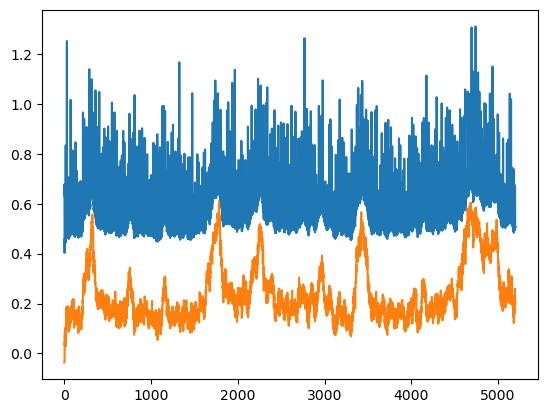

In [31]:
F = np.load(os.path.join(photostim_dir,'F.npy'))
dFF,F,F0,F0_scalar,Fneu = load_and_calculate_dff(photostim_dir,
                                          scalar_f0 = False,
                                          photostim = True,
                                          correct_offset = False)
# im = plt.imshow(dFF_photostim[:,:500],aspect = 'auto')
# im.set_clim([-1,3])
plt.plot(np.mean(F[:,:5200],0)/np.mean(F[:50,:500]))
plt.plot(np.mean(dFF[:,:5200],0))

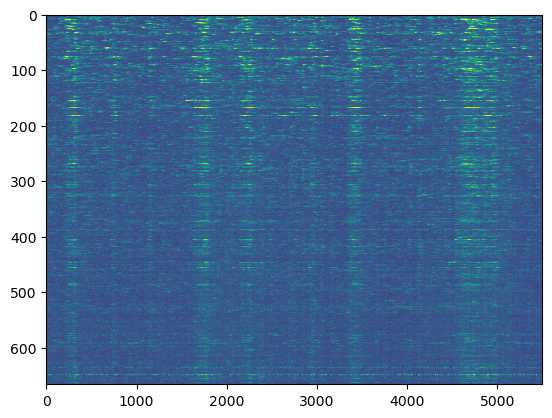

In [130]:

im = plt.imshow(dFF[:,:5500],aspect = 'auto')
im.set_clim([-1,3])

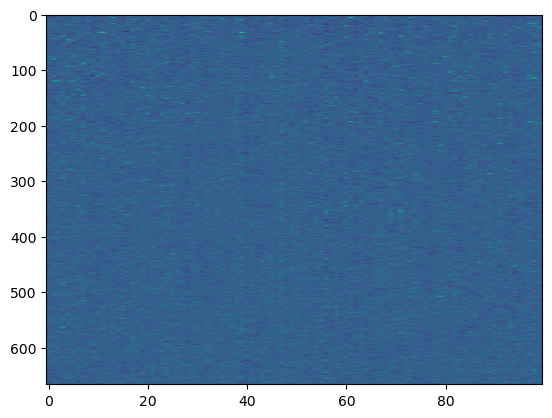

In [131]:
plt.imshow(np.asarray(amplitude_matrix).T/np.asarray(amplitude_std_matrix).T,aspect = 'auto')

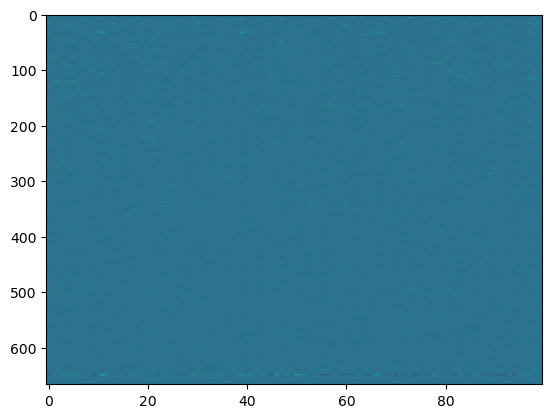

In [133]:
plt.imshow(np.asarray(amplitude_matrix).T,aspect = 'auto')

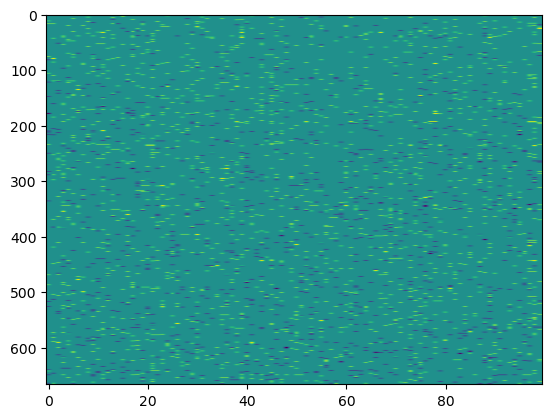

In [134]:
plt.imshow(np.asarray(connectivity).T,aspect = 'auto') # plot vs distance

In [157]:
a = np.nanstd(amplitudes_notaveraged,axis = 1)
a.shape

(775,)

In [101]:
DFF_normalized = DFF_now-np.nanmean(DFF_now[:baseline_length,:],0)
DFF_normalized.shape

/tmp/ipykernel_31553/836976387.py:1: RuntimeWarning: Mean of empty slice
  DFF_normalized = DFF_now-np.nanmean(DFF_now[:baseline_length,:],0)


(30, 775, 21)

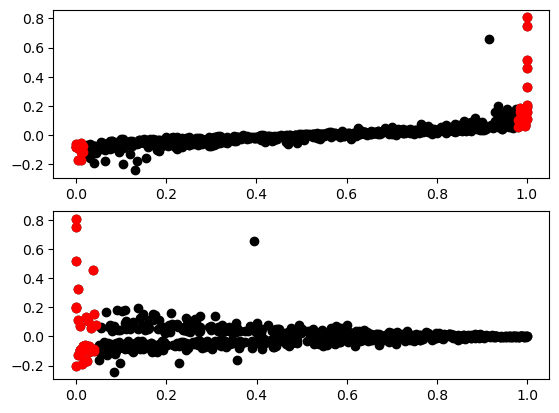

In [22]:
#plt.imshow(DFF_averaged.T,aspect = 'auto')
#plt.plot(np.mean(DFF_averaged_normalized,1))
# photostim_indices
percentiles = np.asarray(percentiles)
amplitdes = np.asarray(amplitudes)
ttest_ps = np.asarray(ttest_ps)

significant = ((percentiles<0.025) | (percentiles>.975))# & (ttest_ps <.05)
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax1.plot(percentiles,amplitudes,'ko')
ax1.plot(percentiles[significant],amplitudes[significant],'ro')

significant = (ttest_ps <.05)

ax2 = fig.add_subplot(2,1,2)
ax2.plot(ttest_ps,amplitudes,'ko')
ax2.plot(ttest_ps[significant],amplitudes[significant],'ro')